# CoreNLP Parsing with NLTK Wrapper

<br>
This utilizes the NLTK Wrapper for CoreNLP in order to parse sentences from BBN/ACCENT to identify additionally verbs to add to PETRARCH Dictionaries to increase precision and Recall
<br>
<br>
Setup Environment

In [1]:
from nltk.parse.corenlp import CoreNLPServer
from nltk.parse.corenlp import CoreNLPDependencyParser
from nltk.parse import CoreNLPParser

import pandas as pd

import pprint
import nltk

from nltk.tree import *
from IPython.display import display

### Server Terminal > cd $CORENLP_HOME
<br>
java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -annotators "tokenize,ssplit,pos,lemma,parse,sentiment" -port 9000 -timeout 30000
<br>
<br>
Connect parser to server running CoreNLP

In [2]:
parser = CoreNLPParser('http://localhost:9000')
depr = CoreNLPDependencyParser('http://localhost:9000')

# NYTBatch50 Accent
#### Read in NYTbatch50 BBN/ACCENT DATA, trim to CAMEO 145, and create a subset of events to test

In [4]:
extract = pd.read_csv('Data/nytextract.csv')
protest_violent = extract[extract.code == 145].reset_index()
small = protest_violent.head()
small

,index,aid,code,text,bad
0,240,22338793,145,\n Yesterday the news agency reported that...,0
1,241,22339503,145,"""Thirty-four men arrested late last night were...",0
2,242,22395783,145,"""In the worst outbreak of street violence in 1...",0
3,243,22398252,145,Paris policemen and leftist extremists clash a...,0
4,244,22407123,145,"Violence occurred through most of the day, des...",0


#### Create regular sentence parser: input data and column

In [3]:
def core_parser(df, col):
    parse = []
    i = ""
    for i in range(len(df)):
        parse.append(i)
        parse[i] = next(parser.raw_parse(df[col].iloc[i]))
    return parse

#### Run core_parser with small batch data

In [49]:
%time protest_violent['parsed'] = core_parser(protest_violent, 'text')

CPU times: user 110 ms, sys: 9.06 ms, total: 119 ms
Wall time: 31.3 s


#### To view each parse-tree, index new column starting at 0

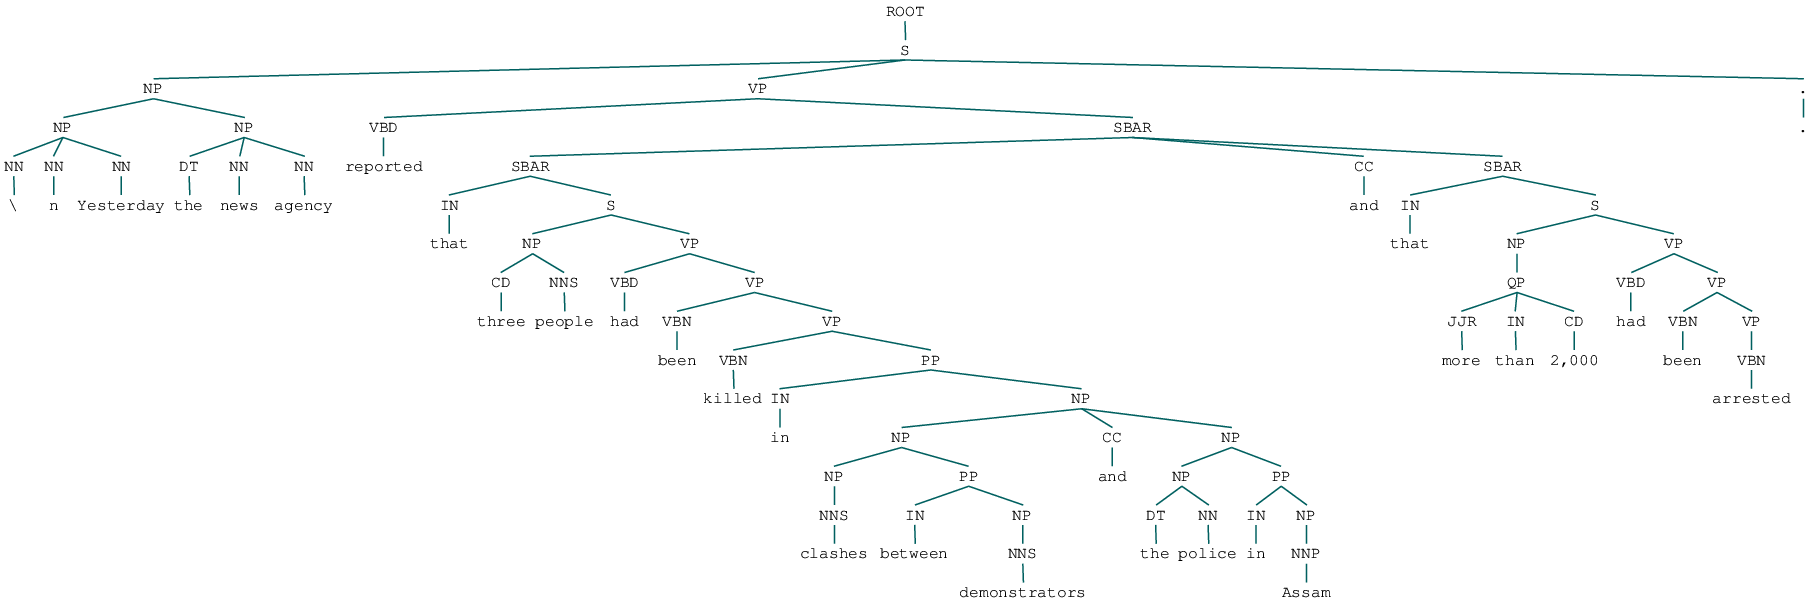

In [51]:
protest_violent['parsed'].iloc[0]

#### Create dependency sentence parser: input data and column

In [4]:
def dep_parser(df, col):
    dep = []
    i = ""
    for i in range(len(df)):
        dep.append(i)
        dep[i] = next(depr.raw_parse(df[col].iloc[i]))
    return dep

#### Run dep_parser with small batch test data

In [52]:
%time protest_violent["dep"] = dep_parser(protest_violent, 'text')

CPU times: user 116 ms, sys: 12.2 ms, total: 129 ms
Wall time: 2.07 s


#### To view each dependency parse-tree, index new column starting at 0

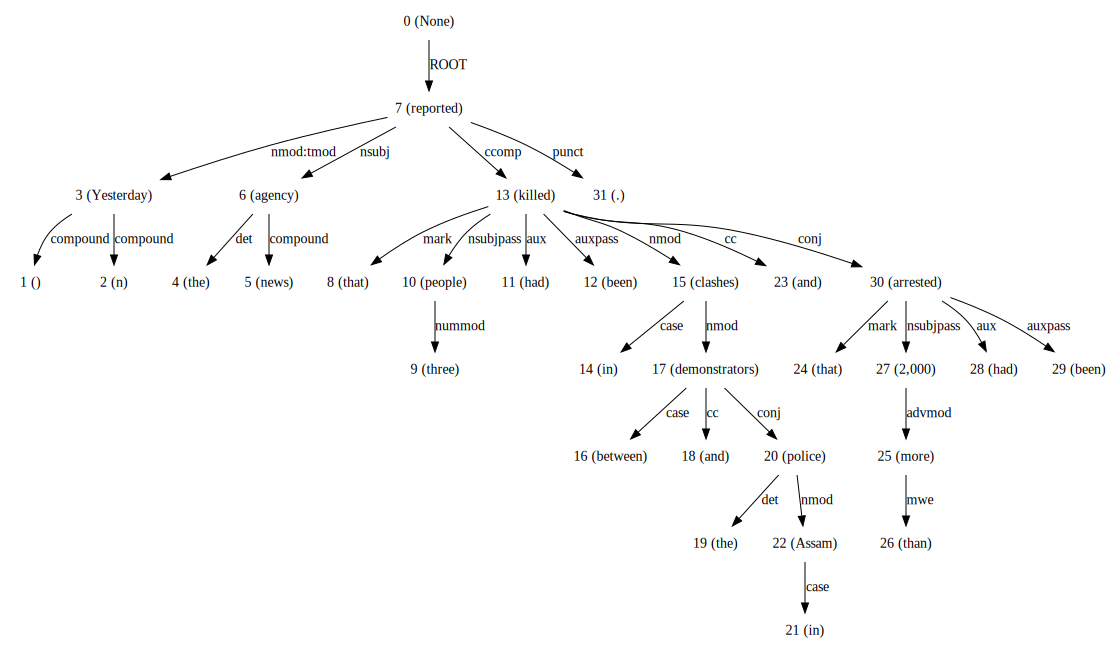

In [53]:
protest_violent["dep"].iloc[0]

#### To view both trees simultaneously, use function 'easy_read' with three arguments (dataframe, index number) (this is provided you use the same naming scheme I used, but easy to change)

In [5]:
def easy_read(corp, index_num):
    display(corp['parsed'].iloc[index_num])
    display(corp['dep'].iloc[index_num])
    display("Text = " + corp.iloc[index_num].loc['text'])
    display("Code = " + str(corp.iloc[index_num].loc['code']))

In [ ]:
easy_read(nyt, nyt_dep, protest_violent, 24, 'text')

In [ ]:
protest_violent

# NYTbd Sample 14-18
Read in data

In [6]:
sample1418 = pd.read_csv("Data/ACCENT NYTbd sample 14 18.csv")

In [7]:
# Trim to Root Code 18
assault = sample1418[sample1418["root_code"] == 18].reset_index().drop(['index'], axis = 1)

In [8]:
%time assault['parsed'] = core_parser(assault, 'text')

CPU times: user 308 ms, sys: 48 ms, total: 356 ms
Wall time: 2min 5s


In [9]:
%time assault['dep'] = dep_parser(assault, 'text')

CPU times: user 329 ms, sys: 44.2 ms, total: 373 ms
Wall time: 22.2 s


# Look at PETRACH and ACCENT 14_18

In [11]:
petrarch1418 = pd.read_csv("Data/PETRARCH output sample 14 18.txt", sep='\t')
petrarch18 = petrarch1418[petrarch1418['root_code']==18].reset_index().drop(['index','Unnamed: 0'], axis = 1)


### Parse PETRARCH Root Code 18

In [12]:
%time petrarch18['parsed'] = core_parser(petrarch18, 'text')
petrarch18['dep'] = dep_parser(petrarch18, 'text')

CPU times: user 95.1 ms, sys: 22.9 ms, total: 118 ms
Wall time: 8.22 s


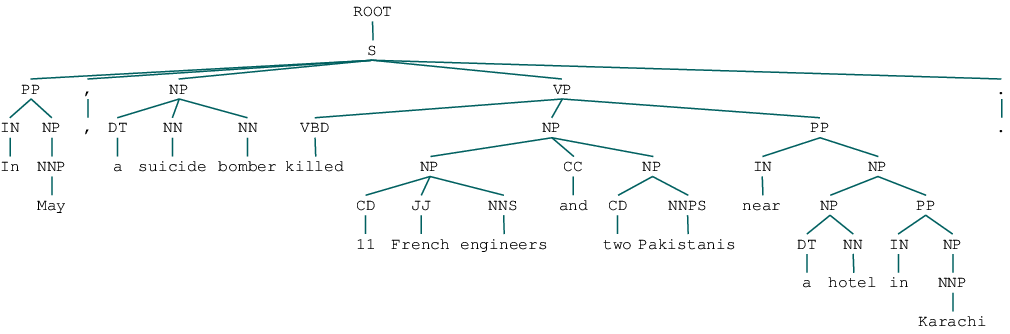

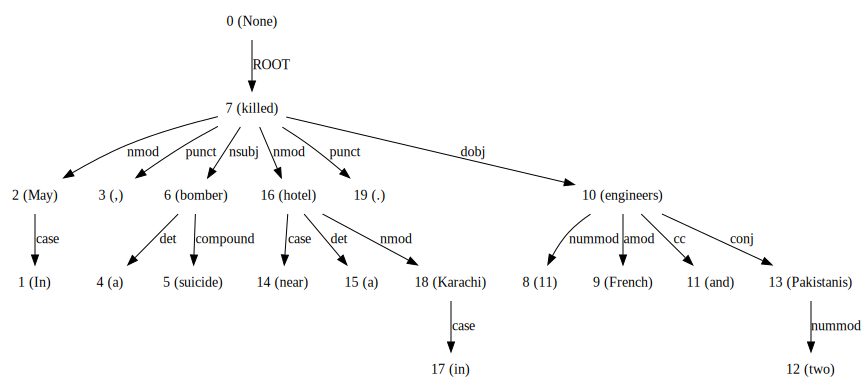

'Text = In May , a suicide bomber killed 11 French engineers and two Pakistanis near a hotel in Karachi .'

'Code = 1831'

In [65]:
easy_read(petrarch18, 18)

### Identify instances where ACCENT and PETRARCH found the same event in the same article

In [13]:
keys = list(["aid", "code"])
petrarch18i1 = petrarch18.set_index(keys).index
assaulti2 = assault.set_index(keys).index
petrarch18_trim = petrarch18[~petrarch18i1.isin(assaulti2)]
both1 = petrarch18[petrarch18i1.isin(assaulti2)]
both_petrarch_coded = both1.sort_values(['aid'])
both_petrarch_coded[['aid', 'code', 'text']]

,aid,code,text
13,22633569,181,The priest was reported to have been kidnapped...
10,22779688,181,"Also in early September , armed gunmen seized ..."
30,22930509,181,The rebels also kidnapped the mayors of the to...
18,23850418,1831,"In May , a suicide bomber killed 11 French eng..."
20,23855995,181,The rebels forced the plane to land and kidnap...
15,23932147,1831,The move by Mr. Arafat came a day after a Pale...
0,23968047,181,In an effort to obtain information about Capta...
12,23976893,1831,Two suicide bombers killed at least 56 people ...
23,24022493,181,More than 400 foreigners and at least 36 journ...
21,24044048,1831,"Ten days earlier , a suicide car bomber in the..."


In [14]:
assaulti1 = assault.set_index(keys).index
petrarch18i2 = petrarch18.set_index(keys).index
assault_trim = assault[~assaulti1.isin(petrarch18i2)]
both2 = assault[assaulti1.isin(petrarch18i2)]
both_accent_coded = both2.sort_values(['aid'])
both_accent_coded[['aid', 'code', 'text']]

,aid,code,text
13,22633569,181,"Urban, the Government spokesman, identified th..."
48,22779688,181,"Also in early September, armed gunmen seized a..."
67,22930509,181,Stepping up their violent effort to stop natio...
29,23850418,1831,"Five people, including three foreigners, were ..."
70,23855995,181,The rebels forced the plane to land and kidnap...
37,23932147,1831,"""Facing renewed threats from Israel, the Pales..."
21,23968047,181,"\n\n\nIn the face of some criticism, Mr. Sharo..."
32,23976893,1831,"""Two suicide bombers killed at least 56 people..."
22,24022493,181,Al Jazeera said she had asked the kidnappers t...
44,24044048,1831,"Ten days earlier, a suicide car bomber in the ..."


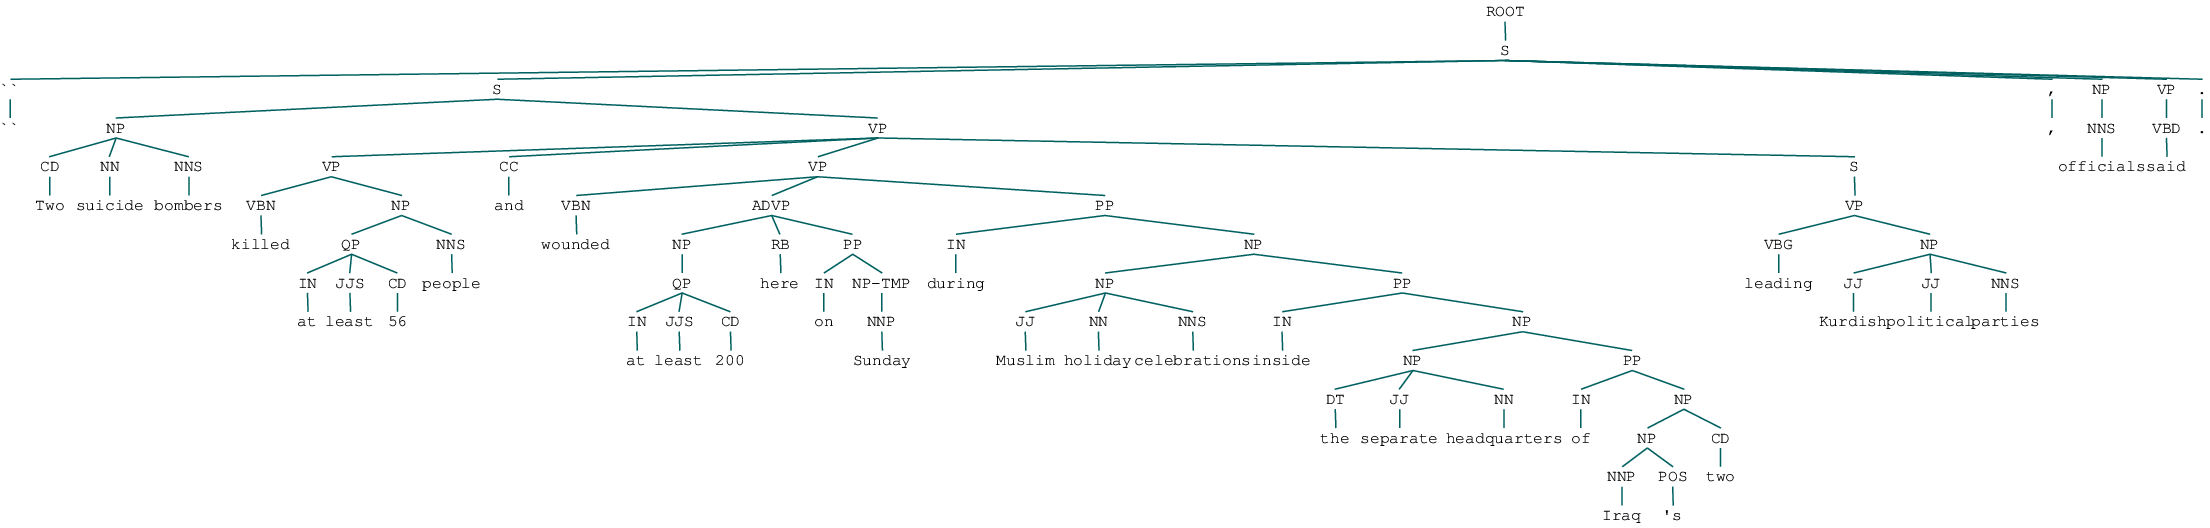

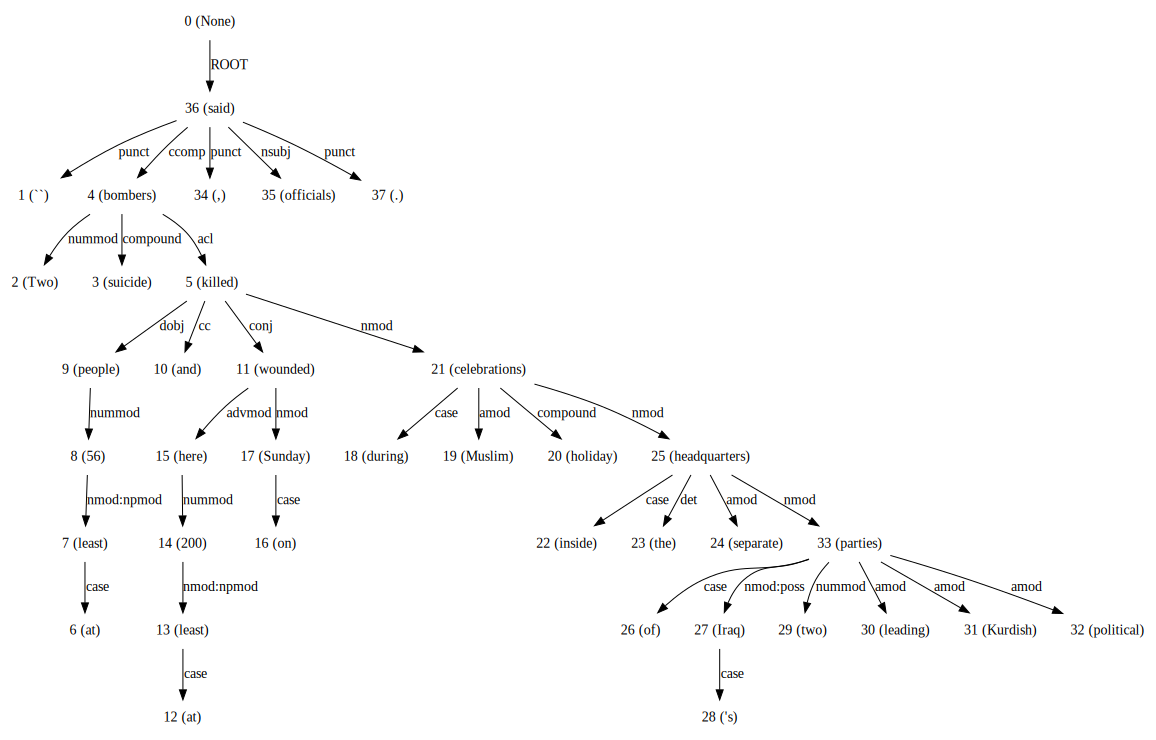

'Text = "Two suicide bombers killed at least 56 people and wounded at least 200 here on Sunday during Muslim holiday celebrations inside the separate headquarters of Iraq\'s two leading Kurdish political parties, officials said.'

'Code = 1831'

In [15]:
easy_read(both_accent_coded, 7)

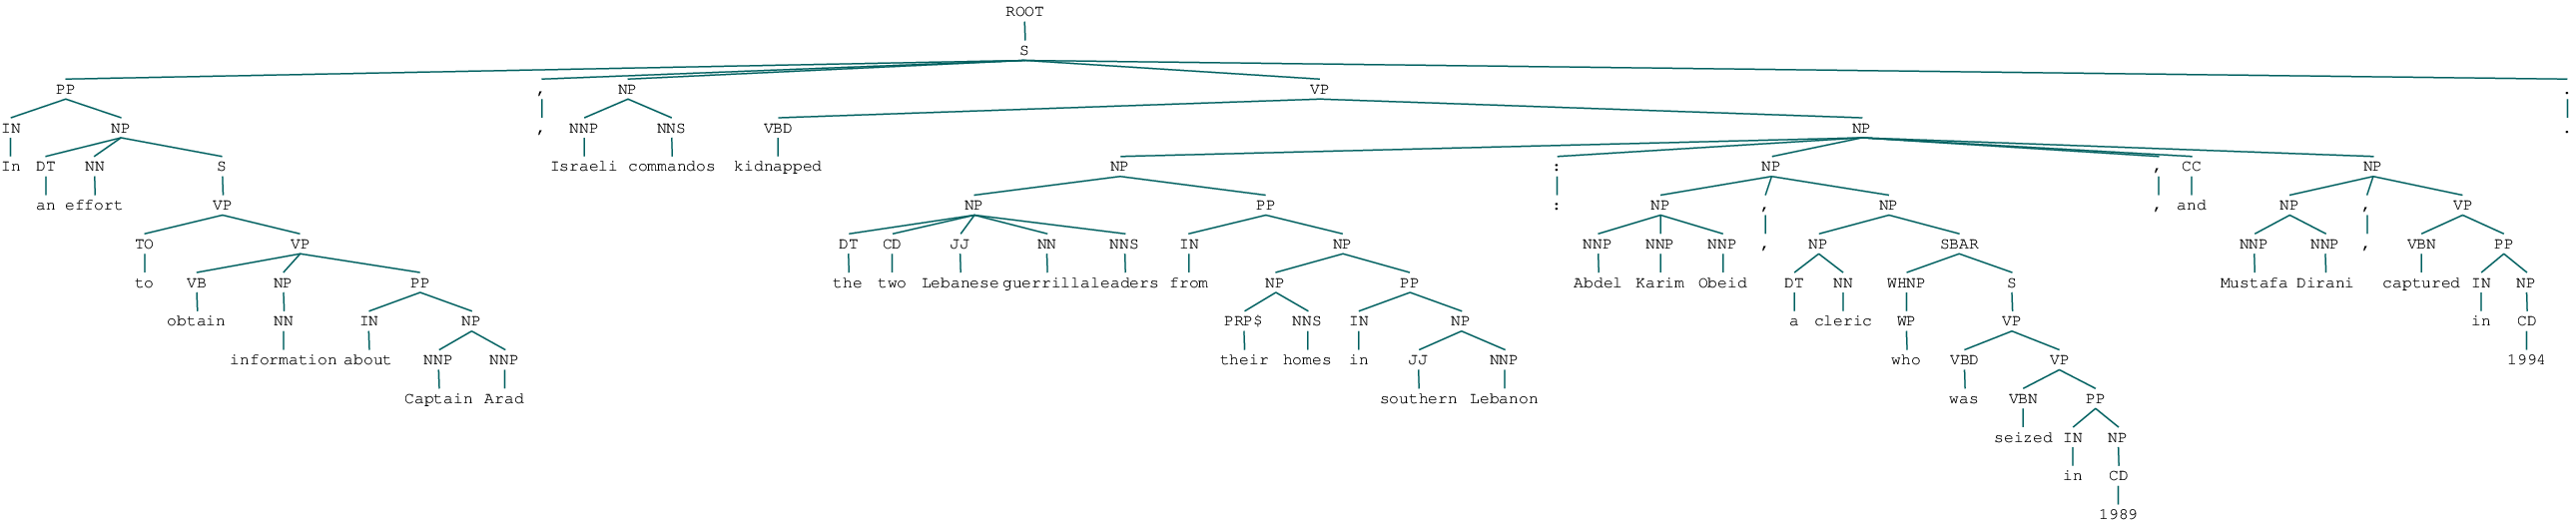

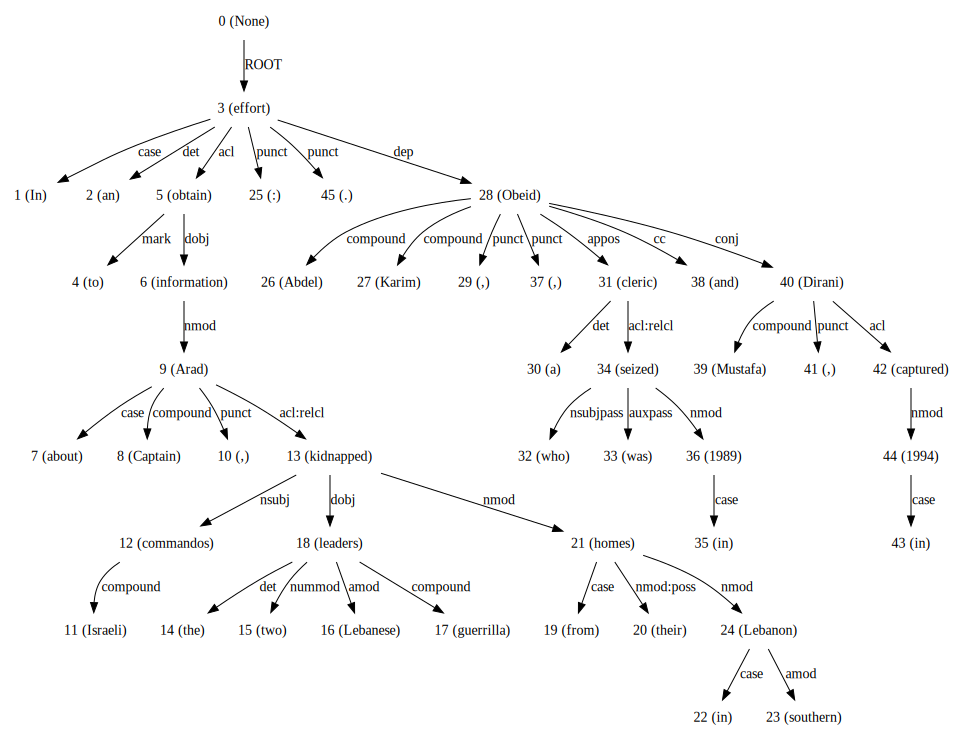

'Text = In an effort to obtain information about Captain Arad , Israeli commandos kidnapped the two Lebanese guerrilla leaders from their homes in southern Lebanon : Abdel Karim Obeid , a cleric who was seized in 1989 , and Mustafa Dirani , captured in 1994 .'

'Code = 181'

In [79]:
easy_read(both_petrarch_coded, )

### Identify instances where ACCENT/PETRARCH found different events in the same article

In [24]:
new_key = list(['aid'])
petrarch18i10 = petrarch18.set_index(new_key).index
assaulti20 = assault.set_index(new_key).index
petrarch18_trim_2 = petrarch18[~petrarch18i10.isin(assaulti20)]
both10 = petrarch18[petrarch18i10.isin(assaulti20)]
both_petrarch_coded2 = both10.sort_values(['aid'])

In [25]:
assaulti10 = assault.set_index(new_key).index
petrarch18i20 = petrarch18.set_index(new_key).index
assault_trim_2 = assault[~assaulti10.isin(petrarch18i20)]
both20 = assault[assaulti10.isin(petrarch18i20)]
both_accent_coded2 = both20.sort_values(['aid'])

In [26]:
i1 = both_petrarch_coded2.set_index(keys).index
i2 = both_accent_coded2.set_index(keys).index
petrarch_trim = both_petrarch_coded2[~i1.isin(i2)]
discard = both_petrarch_coded2[i1.isin(i2)]

In [27]:
i10 = both_accent_coded2.set_index(keys).index
i20 = both_petrarch_coded2.set_index(keys).index
accent_trim = both_accent_coded2[~i10.isin(i20)]
discard2 = both_accent_coded2[i10.isin(i20)]

In [28]:
petrarch_slim = petrarch_trim[['aid', 'text', 'parsed', 'dep', 'code']]
accent_slim = accent_trim[['aid', 'text', 'parsed', 'dep', 'code']]
petrarch_slim.sort_values('aid')

,aid,text,parsed,dep,code
32,22709434,The intended holdup victim evidently shot at h...,[[[(NP (DT The) (JJ intended) (NN holdup) (NN ...,defaultdict(<function DependencyGraph.__init__...,180
29,22935425,At least nine Palestinians were wounded by arm...,"[[[(QP (IN At) (JJS least) (CD nine)), (NNPS P...",defaultdict(<function DependencyGraph.__init__...,180
26,23547196,The sweep overnight Monday was only the second...,"[[[(DT The), (NN sweep)], [(JJ overnight), (NN...",defaultdict(<function DependencyGraph.__init__...,180
5,23809852,Two Palestinian bombers blew themselves up in ...,"[[[(CD Two), (JJ Palestinian), (NNS bombers)],...",defaultdict(<function DependencyGraph.__init__...,183
9,23849693,"`` It hurts me inside , but I can not say anyt...","[[[``], [(S (NP (PRP It)) (VP (VBZ hurts) (NP ...",defaultdict(<function DependencyGraph.__init__...,180
19,23849693,`` The suicide bombers harm Palestinian intere...,"[[[``], [(S\n (NP (DT The) (NN suicide) (NNS ...",defaultdict(<function DependencyGraph.__init__...,180
7,23850418,"In January , the American reporter Daniel Pear...","[[[(IN In), (NP (NNP January))], [,], [(DT the...",defaultdict(<function DependencyGraph.__init__...,181
3,23857690,Suicide bombers driving two explosives-laden v...,"[[[(NP (NN Suicide) (NNS bombers)), (VP (VBG d...",defaultdict(<function DependencyGraph.__init__...,183
16,23889779,The Israeli offensive did not deter a campaign...,"[[[(NP (DT The) (JJ Israeli) (NN offensive)), ...",defaultdict(<function DependencyGraph.__init__...,183
4,23971704,Deadly Car-Bombing in Baghdad A suicide car-bo...,"[[[(NP (JJ Deadly) (NN Car-Bombing)), (PP (IN ...",defaultdict(<function DependencyGraph.__init__...,183


In [20]:
accent_slim.sort_values('aid')

,aid,text,parsed,dep,code
5,22709434,"""A man shot four bystanders when he pulled a g...","[[[``], [(NP\n (NP (DT A) (NN man))\n (VP\n ...",defaultdict(<function DependencyGraph.__init__...,181
40,22935425,"The army opened fire in Dura, south of Hebron,...","[[[(DT The), (NN army)], [(VBD opened), (NP\n ...",defaultdict(<function DependencyGraph.__init__...,181
89,23547196,the armed wing of Hamas that claimed responsi...,"[[[(NP (DT the) (JJ armed) (NN wing)), (PP\n ...",defaultdict(<function DependencyGraph.__init__...,1831
30,23809852,Two Palestinian bombers blew themselves up in ...,"[[[(CD Two), (JJ Palestinian), (NNS bombers)],...",defaultdict(<function DependencyGraph.__init__...,1831
11,23849693,"""Ayman Kabaha, an Israeli Arab student killed ...","[[[``], [(NP\n (NP (NNP Ayman) (NNP Kabaha))\...",defaultdict(<function DependencyGraph.__init__...,1831
77,23857690,"""Suicide bombers driving two explosives-laden ...","[[[``], [(NP (NN Suicide) (NNS bombers)), (VP ...",defaultdict(<function DependencyGraph.__init__...,1831
8,23889779,Dozens of Palestinian gunmen were reported to ...,[[[(NP\n (NP (NNS Dozens))\n (PP (IN of) (NP...,defaultdict(<function DependencyGraph.__init__...,1831
1,23968047,"Anwar Yassin, one of the released Lebanese pri...","[[[(NP\n (NP (NNP Anwar) (NNP Yassin))\n (, ...",defaultdict(<function DependencyGraph.__init__...,1831
28,23971704,"Karbala was founded on the site where Hussein,...","[[[(NNP Karbala)], [(VBD was), (VP\n (VBN fou...",defaultdict(<function DependencyGraph.__init__...,1831
83,23971884,"On Feb. 1, two suicide bombers walked into sep...","[[[(IN On), (NP (NNP Feb.) (CD 1) (, ,) (CD tw...",defaultdict(<function DependencyGraph.__init__...,1831


In [29]:
def quick_aid_check(corp1, corp2, index1, index2):
    print(corp1['aid'].iloc[index1])
    print(corp2['aid'].iloc[index2])

In [30]:
quick_aid_check(petrarch_slim, accent_slim, 8, 6)

23889779
23889779


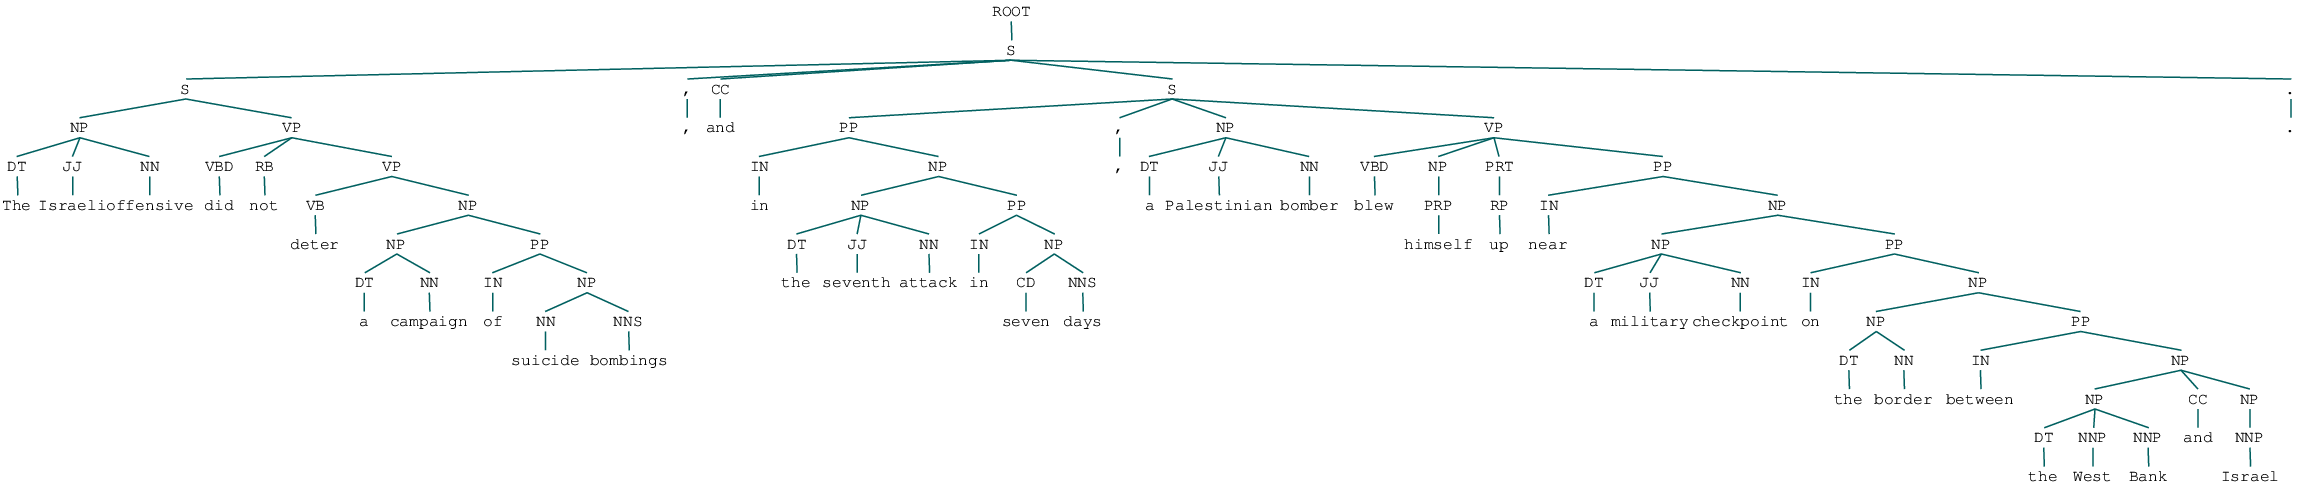

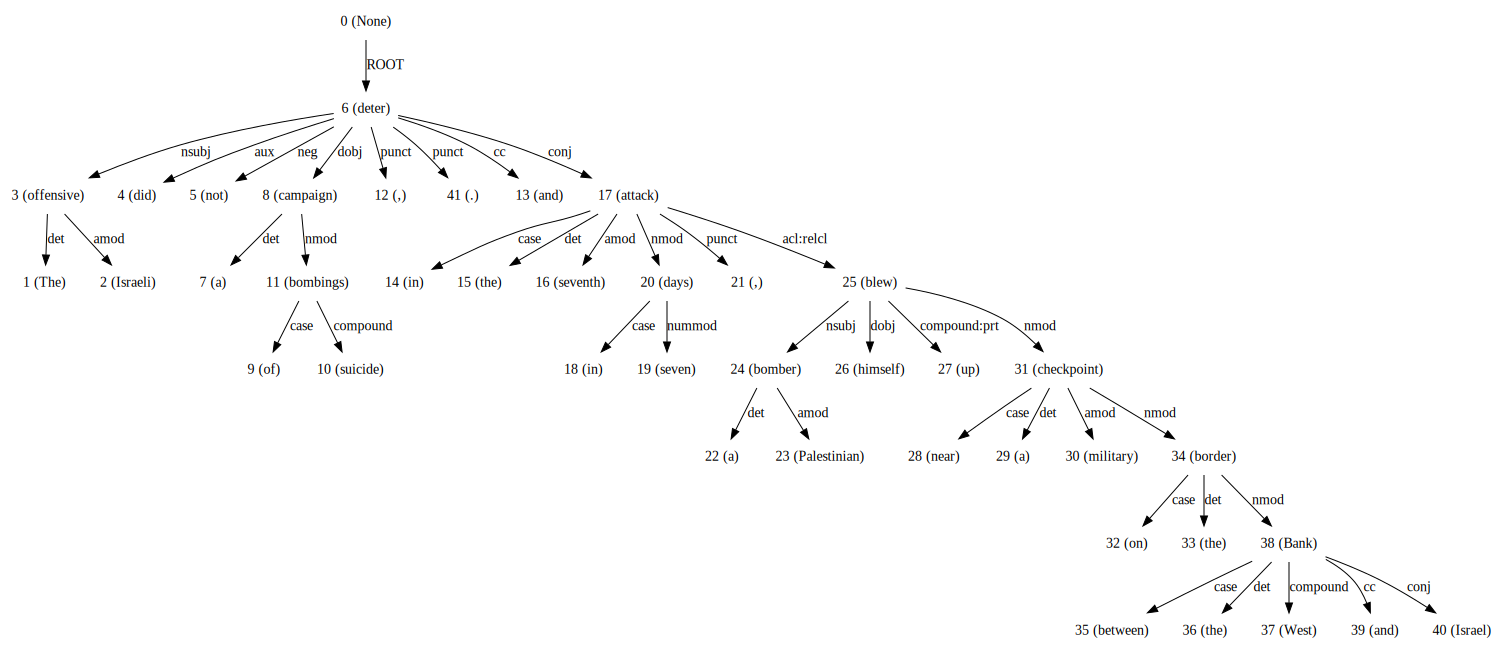

'Text = The Israeli offensive did not deter a campaign of suicide bombings , and in the seventh attack in seven days , a Palestinian bomber blew himself up near a military checkpoint on the border between the West Bank and Israel .'

'Code = 183'

In [30]:
easy_read(petrarch_slim, 8)

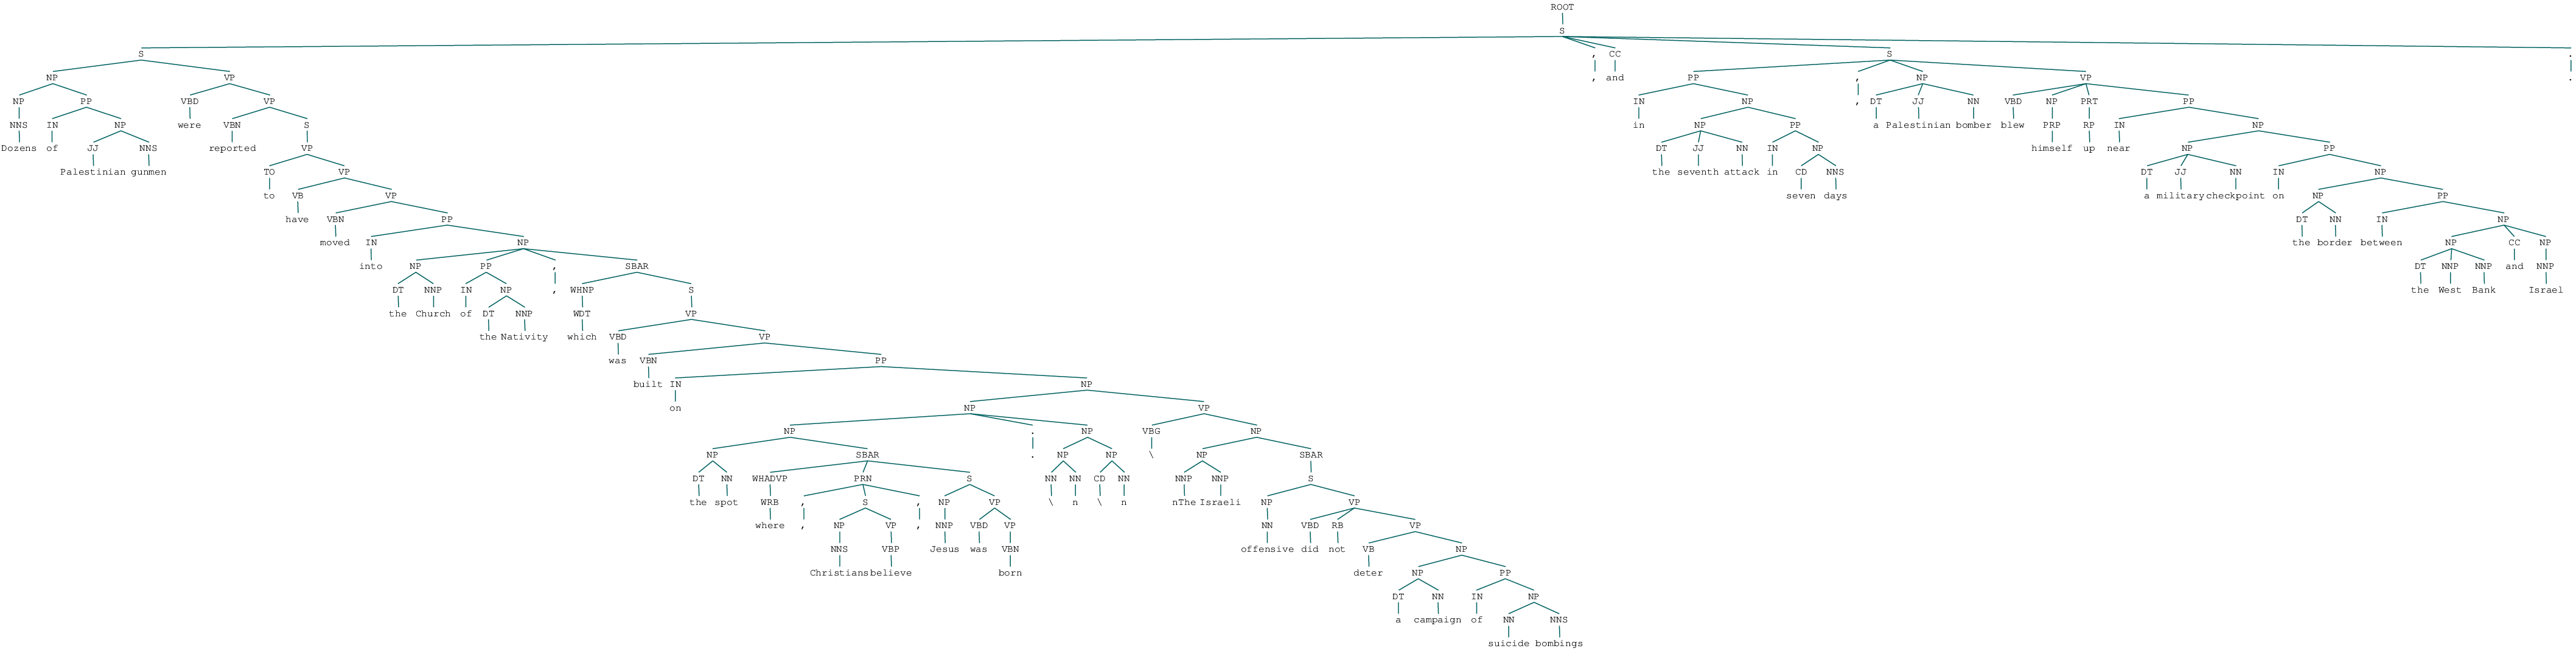

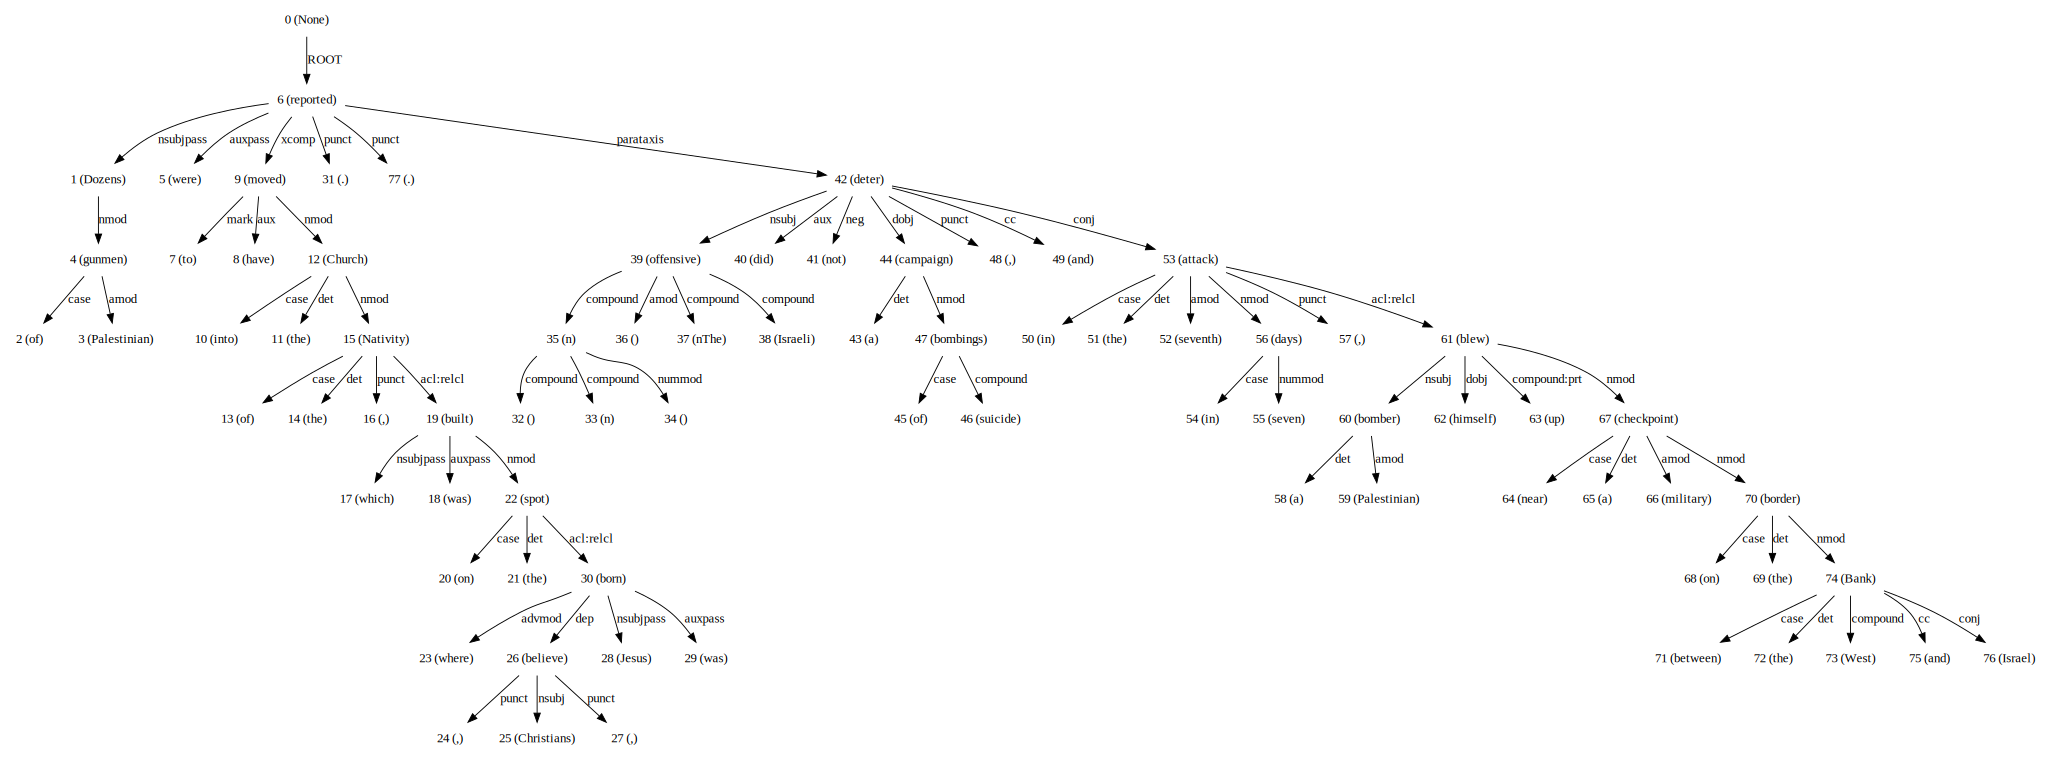

'Text = Dozens of Palestinian gunmen were reported to have moved into the Church of the Nativity, which was built on the spot where, Christians believe, Jesus was born.\\n\\n\\nThe Israeli offensive did not deter a campaign of suicide bombings, and in the seventh attack in seven days, a Palestinian bomber blew himself up near a military checkpoint on the border between the West Bank and Israel.'

'Code = 1831'

In [31]:
easy_read(accent_slim, 6)

### Look at articles ACCENT coded and PETRARCH didn't

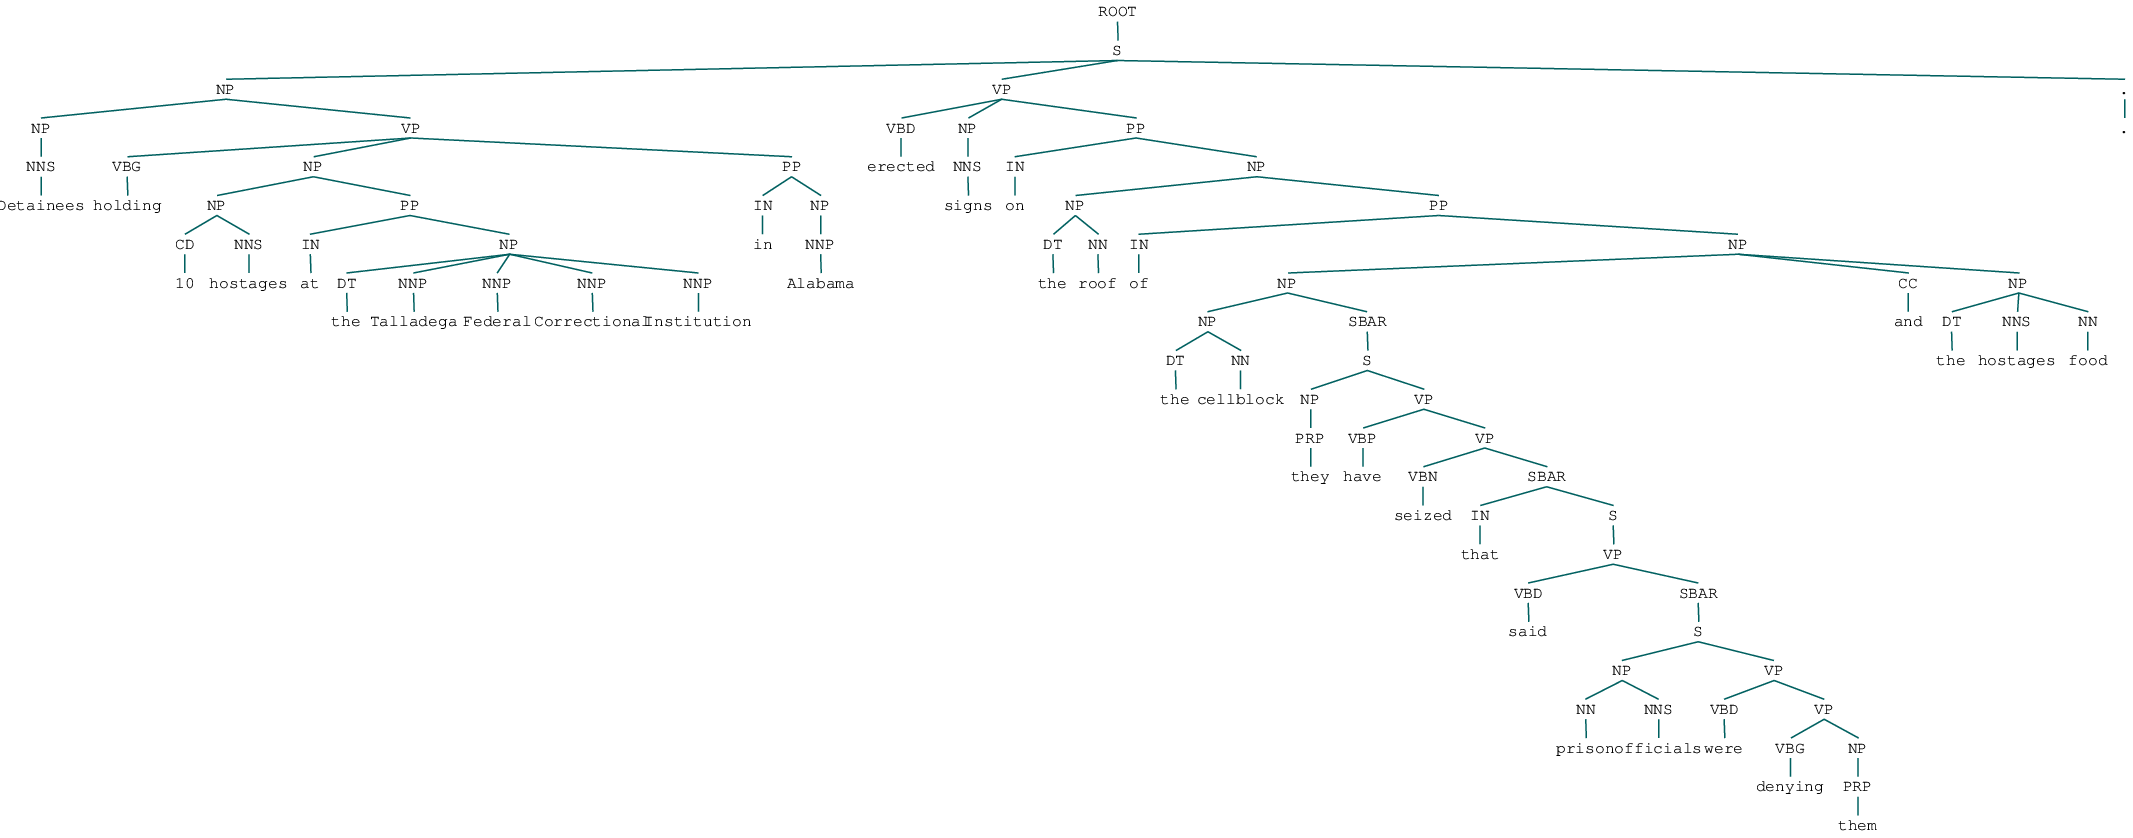

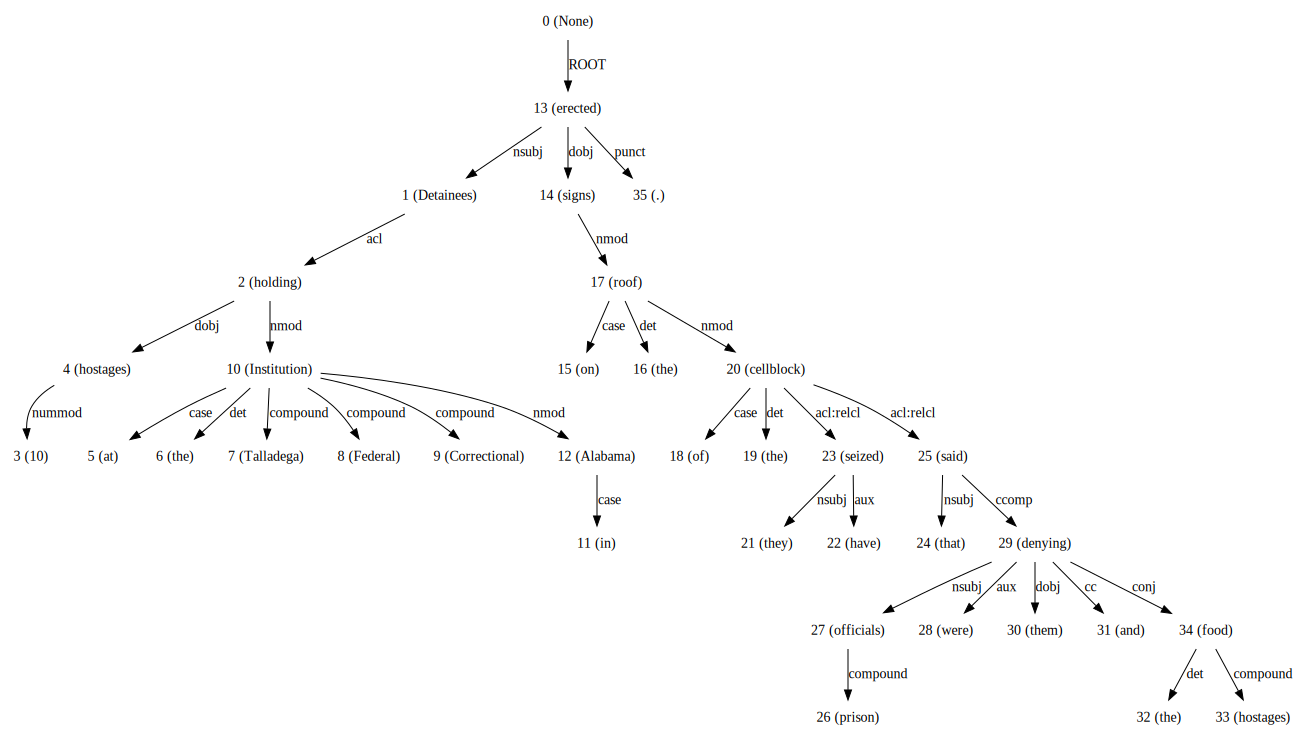

'Text = Detainees holding 10 hostages at the Talladega Federal Correctional Institution in Alabama erected signs on the roof of the cellblock they have seized that said prison officials were denying them and the hostages food.'

'Code = 181'

In [31]:
accent_only_18 = assault_trim_2.reset_index()
easy_read(accent_only_18, 75)

## Look at PETRARCH Null Actor Data

In [64]:
NYTbd_1418_nullactor = pd.read_csv("Data/NYTbd_1418_nullactor.csv")

In [85]:
NYTbd_18_nullactor = NYTbd_1418_nullactor[NYTbd_1418_nullactor['code'].isin([181.1831])]

In [86]:
%time NYTbd_18_nullactor['parsed'] = core_parser(NYTbd_18_nullactor, 'sentence')
NYTbd_18_nullactor['dep'] = dep_parser(NYTbd_18_nullactor, 'sentence')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


CPU times: user 85.2 ms, sys: 125 ms, total: 210 ms
Wall time: 2.48 s


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [89]:
NYTbd_18_nullactor.reset_index()
len(NYTbd_18_nullactor)

9

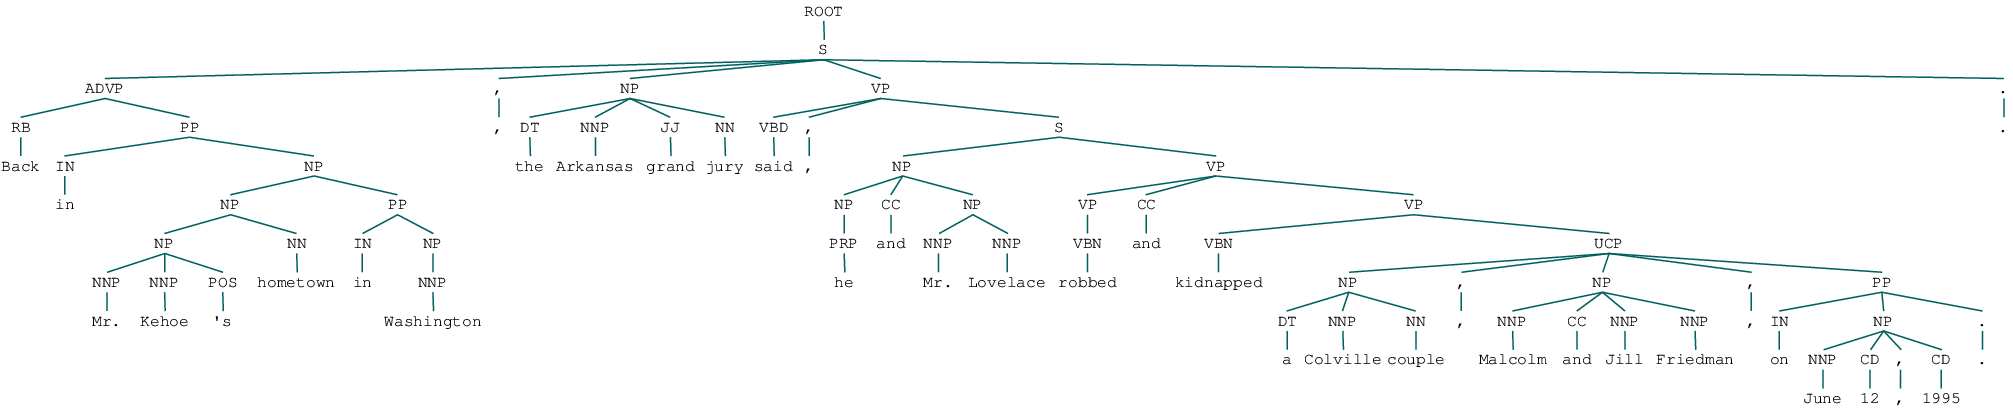

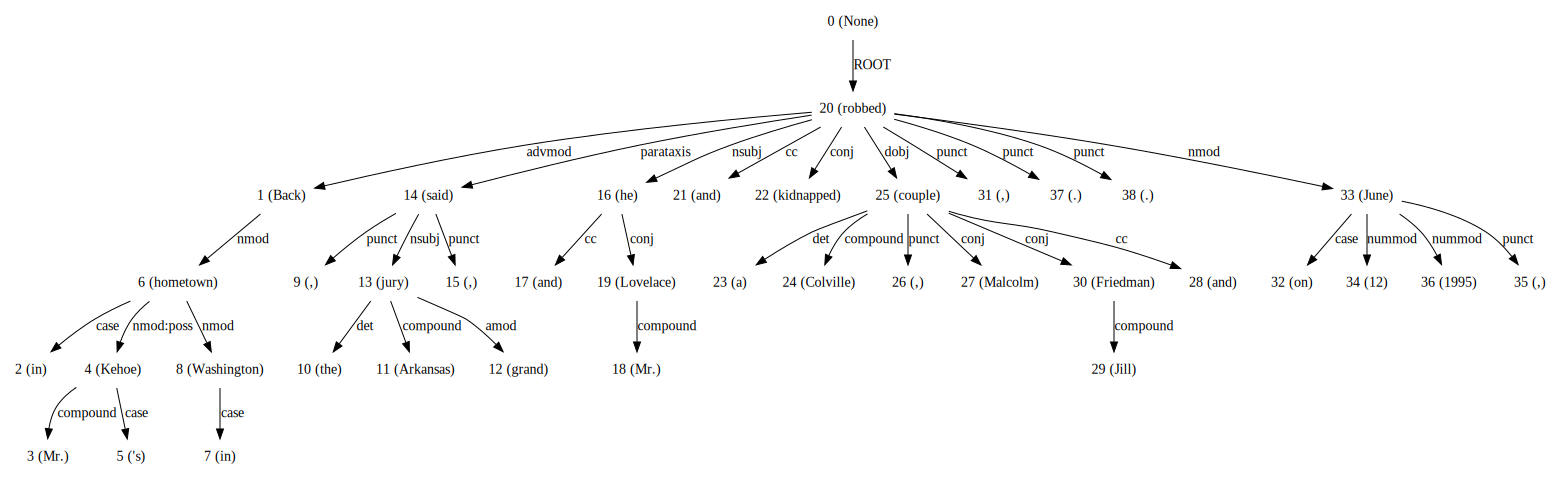

'AID = 23625777'

'Source = Mr. ... Lovelace.'

'Target = a ... Colville couple.'

"Sentence = Back in Mr. Kehoe 's hometown in Washington , the Arkansas grand jury said , he and Mr. Lovelace robbed and kidnapped a Colville couple , Malcolm and Jill Friedman , on June 12 , 1995 .."

'Sentence ID = 34'

'Event Text = <and> ... kidnapped.'

'Code = 181'

In [100]:
easy_read_null_actor(NYTbd_18_nullactor, 8)

## Look at output of PETRARCH after dictionary improvements on 2/11/2020

In [98]:
PETRARCH_02112020 = pd.read_csv("Data/PETRARCH_14_18_NYTbd_2_11_20.csv")
PETRARCH_02112020_18 = PETRARCH_02112020[PETRARCH_02112020['root_code'] == 18]

In [99]:
%time PETRARCH_02112020_18['parsed'] = core_parser(PETRARCH_02112020_18, "text")
PETRARCH_02112020_18['dep'] = dep_parser(PETRARCH_02112020_18, "text")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


CPU times: user 129 ms, sys: 7.07 ms, total: 136 ms
Wall time: 4.91 s


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [120]:
ACCENT_1831 = assault[assault['code'] == 1831]
ACCENT_183 = assault[assault['code'] == 183]
ACCENT_18 = assault[assault['root_code'] == 18]
PETRARCH_02112020_1831 = PETRARCH_02112020_18[PETRARCH_02112020_18['code'] == 1831]
PETRARCH_02112020_183 = PETRARCH_02112020_18[PETRARCH_02112020_18['code'] == 183]
PETRARCH_02112020_181 = PETRARCH_02112020_18[PETRARCH_02112020_18['code'] == 181]

34

In [108]:
pd.options.display.max_colwidth = 1000
PETRARCH_02112020_1831[['code', 'text']]

,code,text
208,1831,"A Palestinian suicide bomber blew himself up Wednesday at a falafel stand in an outdoor market in Hadera , an Israeli coastal town , killing five other people and wounding more than two dozen , the Israeli police said ."
273,1831,"On June 15 , a suicide bomber wearing an army uniform blew himself up in an Iraqi Army mess hall in Khalis , killing 26 soldiers ."
317,1831,"Ten days earlier , a suicide car bomber in the Shiite city of Hilla killed at least 136 people , mostly Iraqi police and army recruits ."
363,1831,"Two suicide bombers killed at least 56 people and wounded at least 200 here on Sunday during Muslim holiday celebrations inside the separate headquarters of Iraq 's two leading Kurdish political parties , officials said ."
368,1831,"In May , a suicide bomber killed 11 French engineers and two Pakistanis near a hotel in Karachi ."
471,1831,"The Israeli offensive did not deter a campaign of suicide bombings , and in the seventh attack in seven days , a Palestinian bomber blew himself up near a military checkpoint on the border between the West Bank and Israel ."
496,1831,The move by Mr. Arafat came a day after a Palestinian suicide bomber killed 19 people in northern Israel .


In [109]:
pd.options.display.max_colwidth = 1000
PETRARCH_02112020_181[['code', 'text']]

,code,text
253,181,The rebels forced the plane to land and kidnapped a passenger .
345,181,"More than 400 foreigners and at least 36 journalists have been kidnapped in Iraq since 2003 , along with thousands of Iraqis ."
415,181,The rebels also kidnapped the mayors of the town of Cojutepeque in Santa Ana dapartment and the town of San Miguel de Mercedes in Chalatenango department .
552,181,"In an effort to obtain information about Captain Arad , Israeli commandos kidnapped the two Lebanese guerrilla leaders from their homes in southern Lebanon : Abdel Karim Obeid , a cleric who was seized in 1989 , and Mustafa Dirani , captured in 1994 ."
568,181,"In January , the American reporter Daniel Pearl was kidnapped in Karachi and later killed ."
589,181,The priest was reported to have been kidnapped Oct. 19 by armed men who used their car to block Father Popieluszko 's auto near Torun and then drove away with him .
617,181,"Also in early September , armed gunmen seized a Pan American World Airways flight in Karachi , Pakistan , and took the passengers hostage ."


In [111]:
pd.options.display.max_colwidth = 1000
PETRARCH_02112020_183[['code', 'text']]

,code,text
48,183,"Two Palestinian bombers blew themselves up in a pedestrian mall in Jerusalem , killing 11 people ."
300,183,"In Dhaka , anti government rioters ransacked or threw bombs at the homes of one political leader and one member of Parliament from the ruling National Party ."
502,183,"But on Sept. 5 , Specialist Williams , a 20-year old medic , was killed by a roadside bomb in Tal Afar , Iraq ."
598,183,Deadly Car-Bombing in Baghdad A suicide car-bomb exploded Thursday morning in a line of vehicles at an American checkpoint on a bridge that leads to the compound that houses many of the American administrators in Iraq .
602,183,"The car bomb in Baghdad exploded at 7:40 a.m. on Wednesday outside the recruiting station of the Iraqi Army headquarters , killing at least 25 Iraqis , said Staff sergeant Shane Slaughter , a spokesman for the American military ."
624,183,"Suicide bombers driving two explosives-laden vehicles blew up the headquarters of Chechnya 's pro-Russian government , killing at least 46 people and wounding more than 75 in one of the deadliest bombings in more than three years of war in Chechnya ."


## Look at Suicide Bombings that ACCENT found that 02112020 PETRARCH did not find

In [121]:
ACCENT_1831 # Accent Suicide Bombings
PETRARCH_02112020_1831 # PETRARCH SUICIDE BOMBINGS
keys = list(["aid", "code"])
PETRARCH_02112020_1831i = PETRARCH_02112020_1831.set_index(keys).index
ACCENT_1831i2 = ACCENT_1831.set_index(keys).index
PETRARCH_02112020_1831_trim = PETRARCH_02112020_1831[~PETRARCH_02112020_1831i.isin(ACCENT_1831i2)]
both1 = PETRARCH_02112020_1831[PETRARCH_02112020_1831i.isin(ACCENT_1831i2)]
both_1831_petrarch_coded = both1.sort_values(['aid'])
aid_remove_petrarch = both_1831_petrarch_coded[['aid']]

In [123]:
ACCENT_1831_MINUS_PETRARCH = ACCENT_1831
cond = ACCENT_1831_MINUS_PETRARCH['aid'].isin(aid_remove_petrarch['aid']) == True
ACCENT_1831_MINUS_PETRARCH.drop(ACCENT_1831_MINUS_PETRARCH[cond].index, inplace = True)
ACCENT_1831_MINUS_PETRARCH.reset_index()

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,index,document_id,aid,sentence_id,date_str,date,year,month,day,event_tense,...,source_agent_name,target_actor_id,target_actor_name,target_country_codes,target_agent_id,target_agent_name,text,batch,parsed,dep
0,1,NYTborndigital_20040130_23968047,23968047,1,20040130,01/30/2004,2004,1,30,historical,...,Armed Gang,31843.0,Israel,IL,173.0,Citizen,"Anwar Yassin, one of the released Lebanese pri...",44,"[[[(NP\n (NP (NNP Anwar) (NNP Yassin))\n (, ...",defaultdict(<function DependencyGraph.__init__...
1,2,NYTborndigital_20050111_24026263,24026263,18,20050111,01/11/2005,2005,1,11,neutral,...,NaN,31843.0,Israel,IL,NaN,NaN,"The militant group Hamas, which has carried ou...",59,[[[(NP (DT The) (JJ militant) (NN group) (NNP ...,defaultdict(<function DependencyGraph.__init__...
2,3,NYTborndigital_20020708_23851804,23851804,66,20020708,07/08/2002,2002,7,8,current,...,Armed Gang,31843.0,Israel,IL,173.0,Citizen,\nHe walked down the hall to see a patient who...,69,"[[[(X (SYM \)), (NP (NN nHe))], [(VBD walked),...",defaultdict(<function DependencyGraph.__init__...
3,6,NYTborndigital_20020420_23862466,23862466,6,20020420,04/20/2002,2002,4,20,neutral,...,Armed Gang,34539.0,"Palestinian Territory, Occupied",PS,NaN,NaN,It wounded two Israeli soldiers as the bomber ...,34,"[[[(PRP It)], [(VBD wounded), (NP (CD two) (JJ...",defaultdict(<function DependencyGraph.__init__...
4,7,NYTborndigital_20020419_23887704,23887704,21,20020419,04/19/2002,2002,4,19,neutral,...,Attacker,31843.0,Israel,IL,173.0,Citizen,The couple were among 28 people killed by a su...,79,"[[[(NP (DT The) (NN couple)), (VP\n (VBD were...",defaultdict(<function DependencyGraph.__init__...
5,9,NYTborndigital_20051026_24068728,24068728,124,20051026,10/26/2005,2005,10,26,historical,...,Citizen,43427.0,United Nations,NaN,NaN,NaN,U.S. forces begin an assault on Baghdad.\nMay...,84,"[[[(NP (NNP U.S.) (NNS forces)), (VP\n (VBP b...",defaultdict(<function DependencyGraph.__init__...
6,11,NYTborndigital_20020620_23849693,23849693,0,20020620,06/20/2002,2002,6,20,current,...,Armed Gang,31843.0,Israel,IL,601.0,Student,"""Ayman Kabaha, an Israeli Arab student killed ...",84,"[[[``], [(NP\n (NP (NNP Ayman) (NNP Kabaha))\...",defaultdict(<function DependencyGraph.__init__...
7,19,NYTborndigital_20050211_24031201,24031201,0,20050211,02/11/2005,2005,2,11,historical,...,Attacker,31853.0,Iraq,IQ,173.0,Citizen,"""A black-robed suicide attacker exploded an en...",74,"[[[(`` ``), (DT A), (JJ black-robed), (NN suic...",defaultdict(<function DependencyGraph.__init__...
8,23,NYTborndigital_20050713_24054078,24054078,29,20050713,07/13/2005,2005,7,13,current,...,Armed Gang,31843.0,Israel,IL,NaN,NaN,Israeli troops carried out arrest raids in th...,44,[[[(NP\n (NP (JJ Israeli) (NNS troops))\n (S...,defaultdict(<function DependencyGraph.__init__...
9,26,NYTborndigital_20020506_23885794,23885794,12,20020506,05/06/2002,2002,5,6,neutral,...,NaN,31843.0,Israel,IL,NaN,NaN,\n\n\nA Western diplomat said the Israeli offi...,79,"[[[(SYM \)], [(NP (NN n) (NN \) (NN n)), (SBAR...",defaultdict(<function DependencyGraph.__init__...


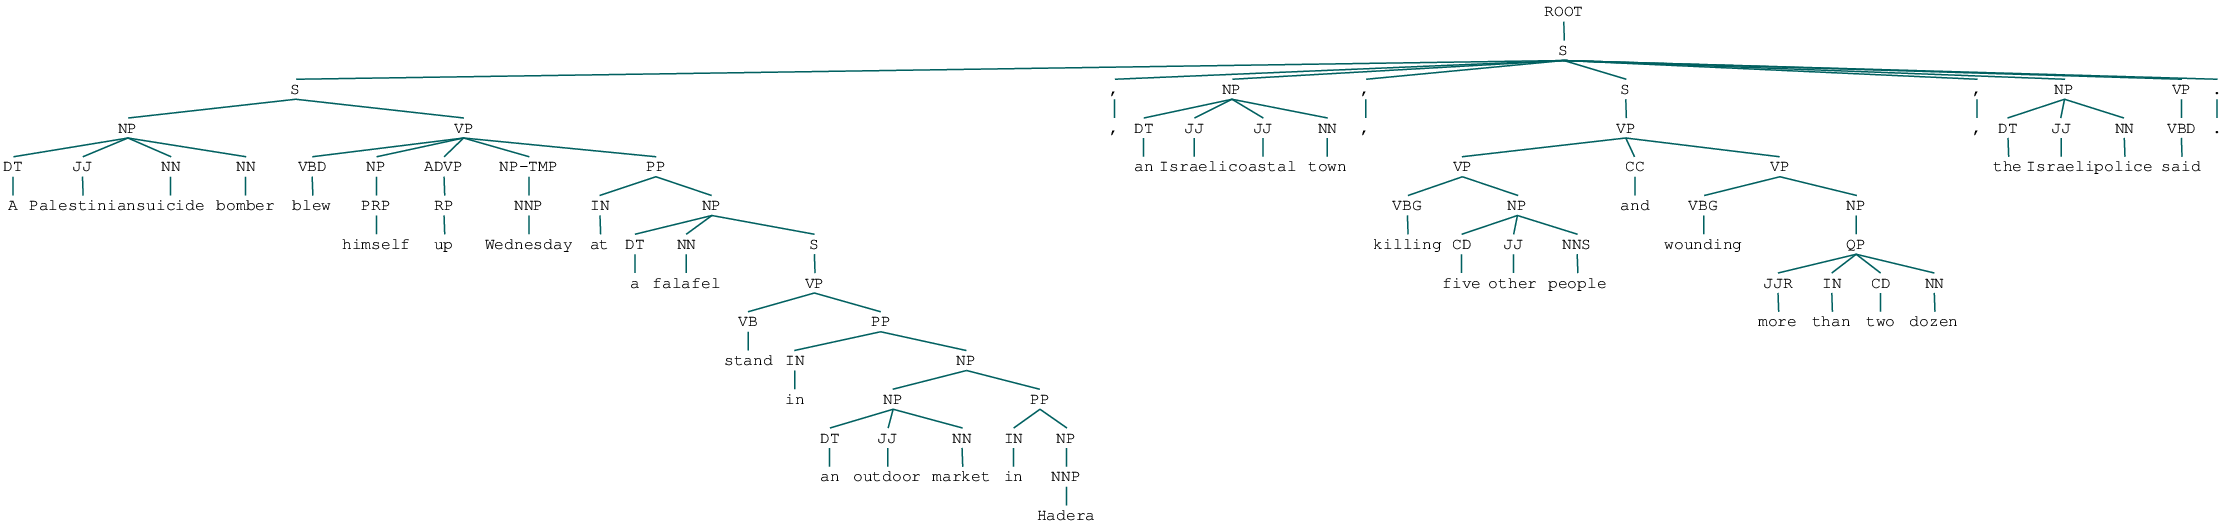

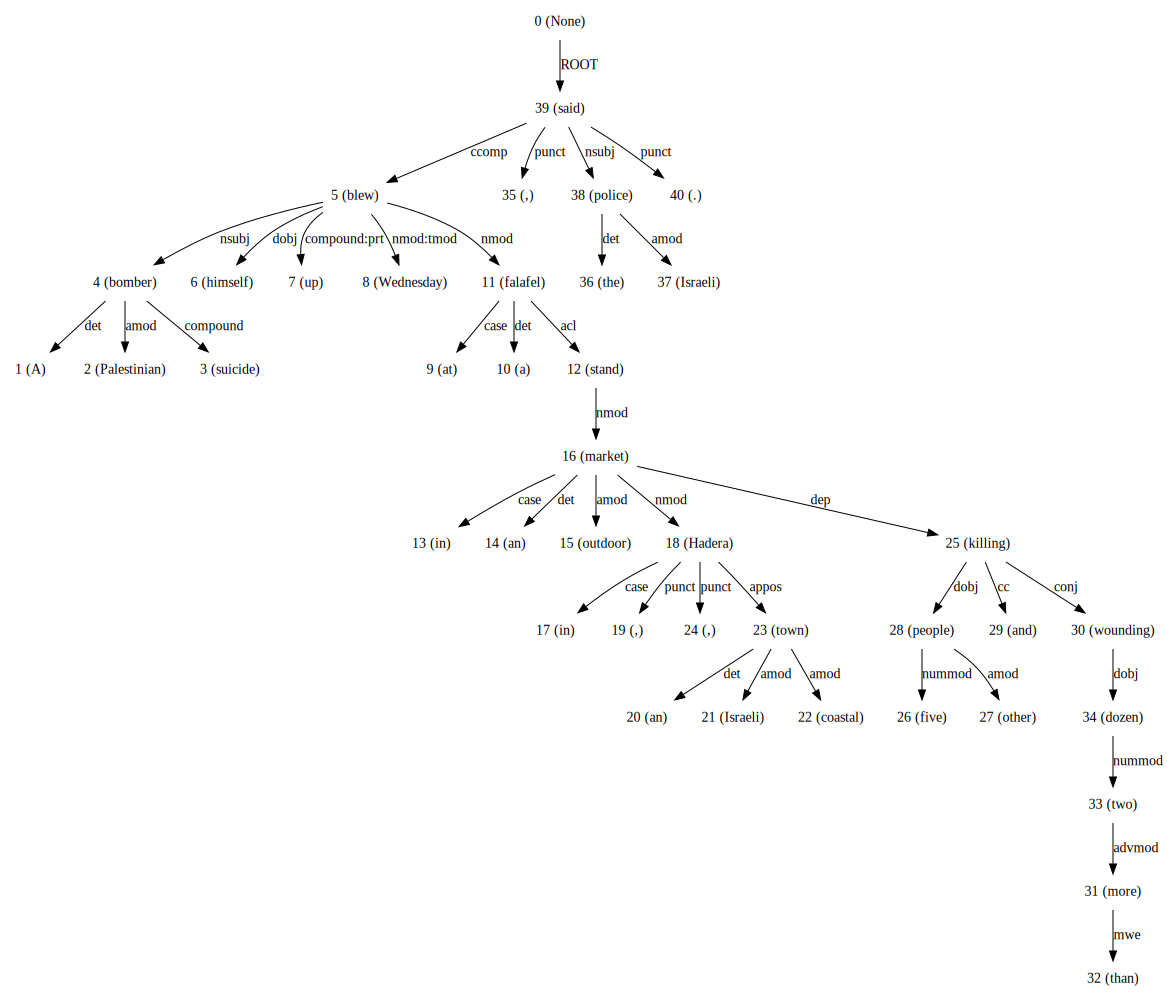

'Text = A Palestinian suicide bomber blew himself up Wednesday at a falafel stand in an outdoor market in Hadera , an Israeli coastal town , killing five other people and wounding more than two dozen , the Israeli police said .'

'Code = 1831'

In [119]:
easy_read(both_1831_petrarch_coded, 6)

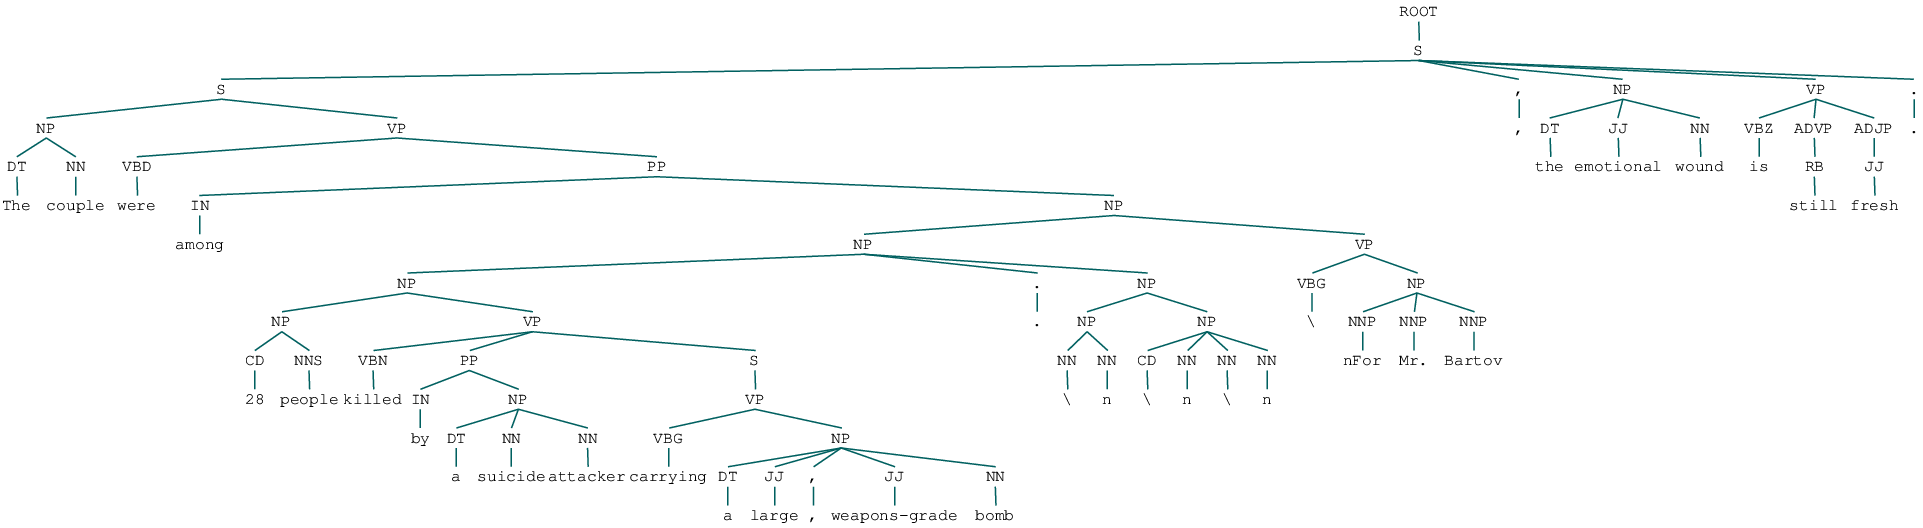

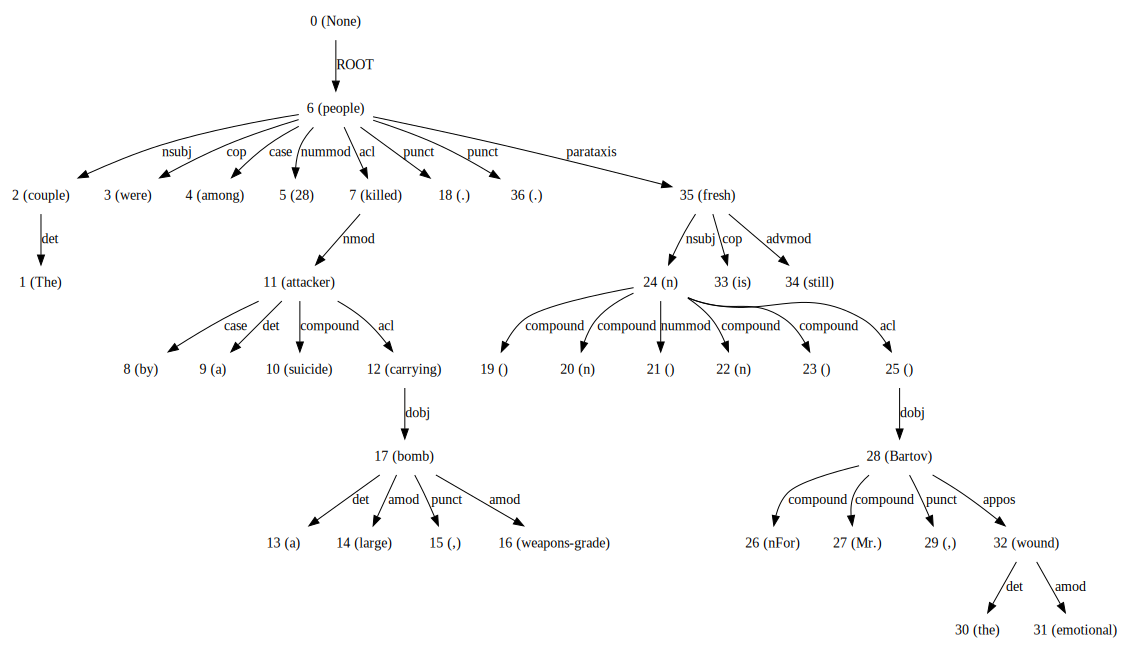

'Text = The couple were among 28 people killed by a suicide attacker carrying a large, weapons-grade bomb.\\n\\n\\n\\nFor Mr. Bartov, the emotional wound is still fresh.'

'Code = 1831'

In [61]:
easy_read(ACCENT_1831, 4)

## Look at articles where ACCENT coded 1831 and  02112020 PETRARCH found different events

In [199]:
new_key = list(['aid'])
PETRARCH_02112020_18i = PETRARCH_02112020_18.set_index(new_key).index
ACCENT_1831i = ACCENT_1831.set_index(new_key).index
PETRARCH_02112020_TRIM = PETRARCH_02112020_18[~PETRARCH_02112020_18i.isin(ACCENT_1831i)]
SAME_AID_PETRARCH_02112020_18 = PETRARCH_02112020_18[PETRARCH_02112020_18i.isin(ACCENT_1831i)]
SAME_AID_PETRARCH_02112020_18 = SAME_AID_PETRARCH_02112020_18.sort_values('aid').reset_index()

In [200]:
ACCENT_TRIM = ACCENT_1831[~ACCENT_1831i.isin(PETRARCH_02112020_18i)]
BOTH_ACCENT_1831 = ACCENT_1831[ACCENT_1831i.isin(PETRARCH_02112020_18i)]
SAME_AID_ACCENT_1831_CODED = BOTH_ACCENT_1831.sort_values(['aid'])
SAME_AID_ACCENT_1831_CODED = SAME_AID_ACCENT_1831_CODED.sort_values('aid').reset_index()

In [202]:
quick_aid_check(SAME_AID_PETRARCH_02112020_18, SAME_AID_ACCENT_1831_CODED, 0, 0)

23547196
23547196


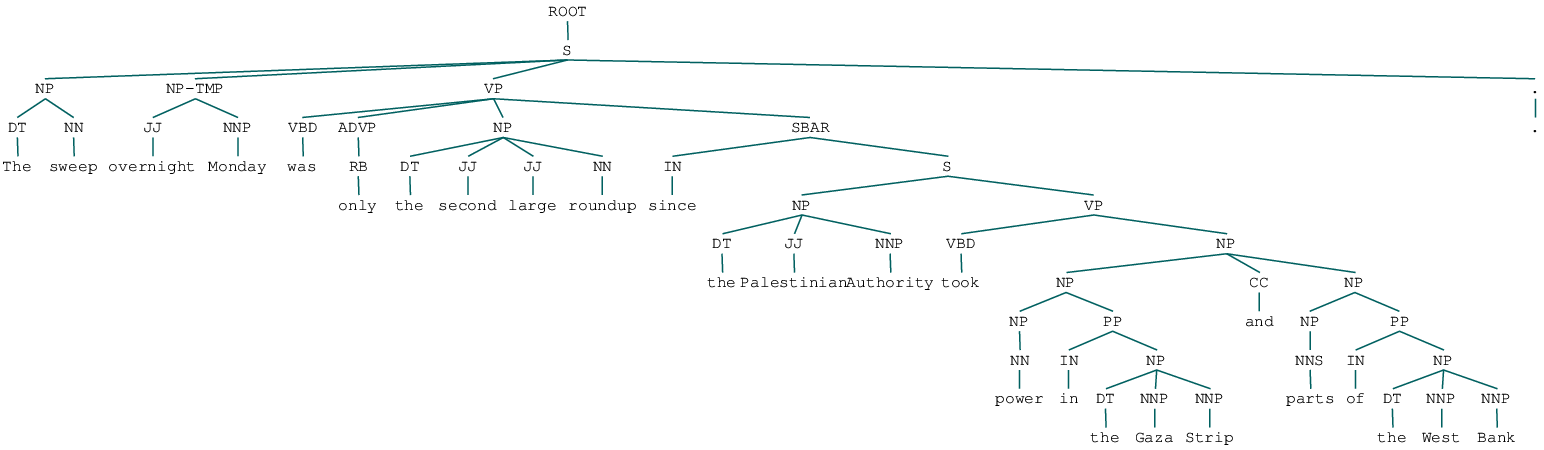

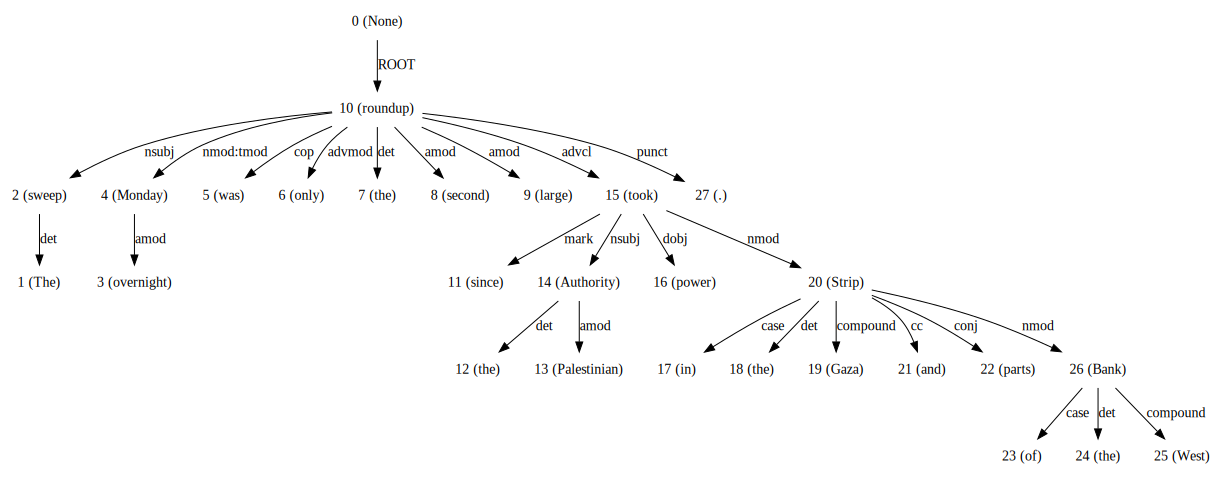

'Text = The sweep overnight Monday was only the second large roundup since the Palestinian Authority took power in the Gaza Strip and parts of the West Bank .'

'Code = 180'

In [205]:
easy_read(SAME_AID_PETRARCH_02112020_18, 0)

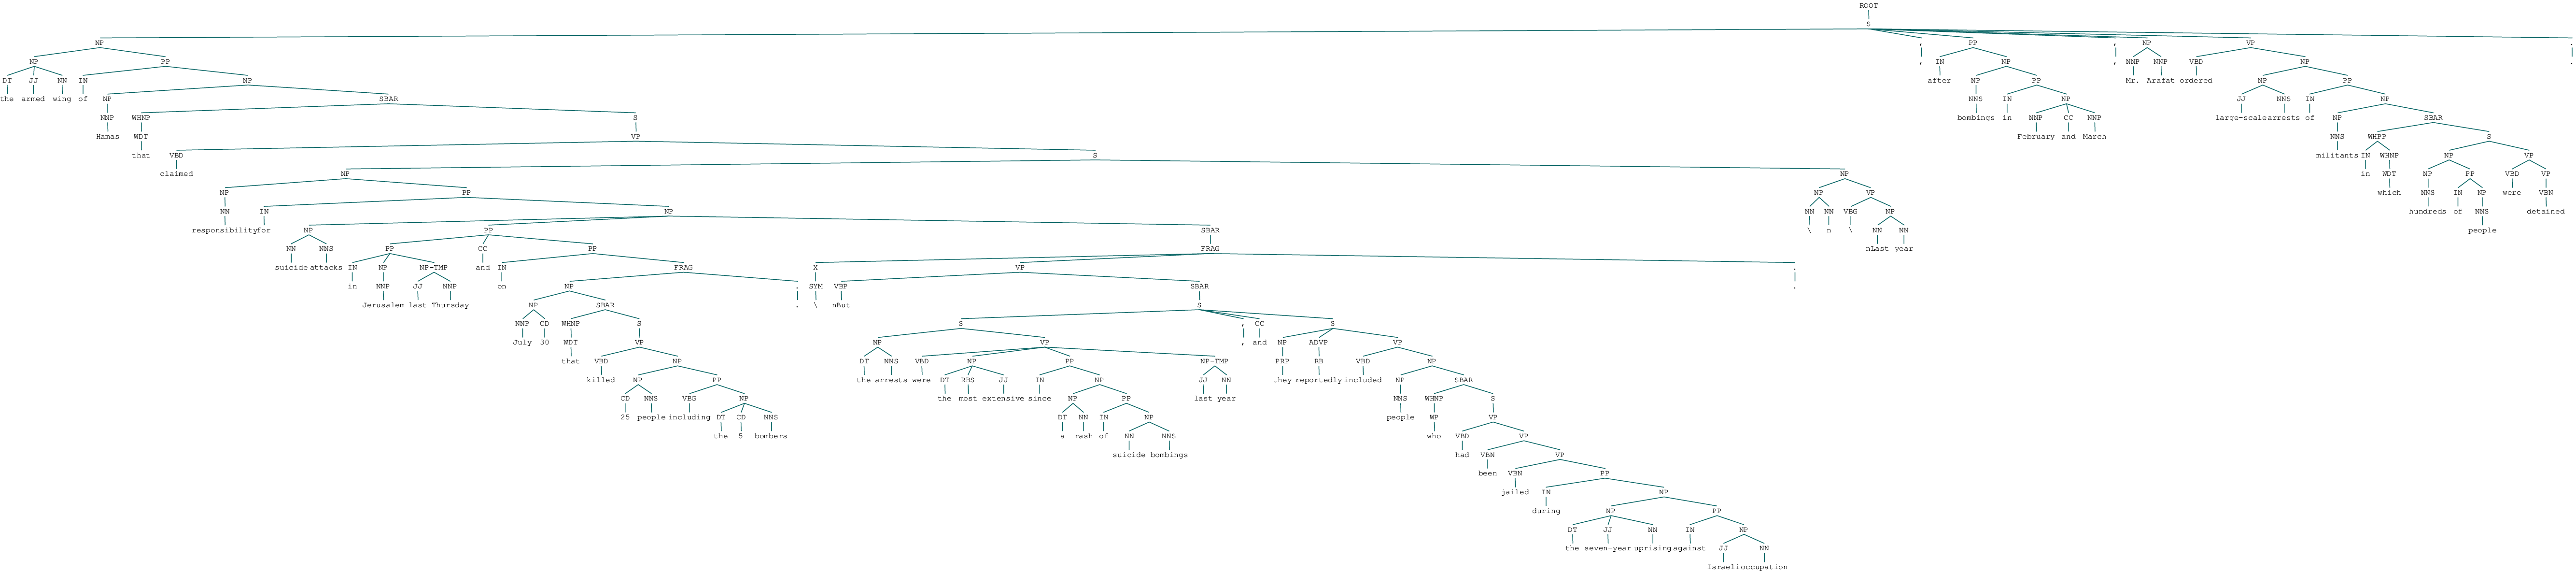

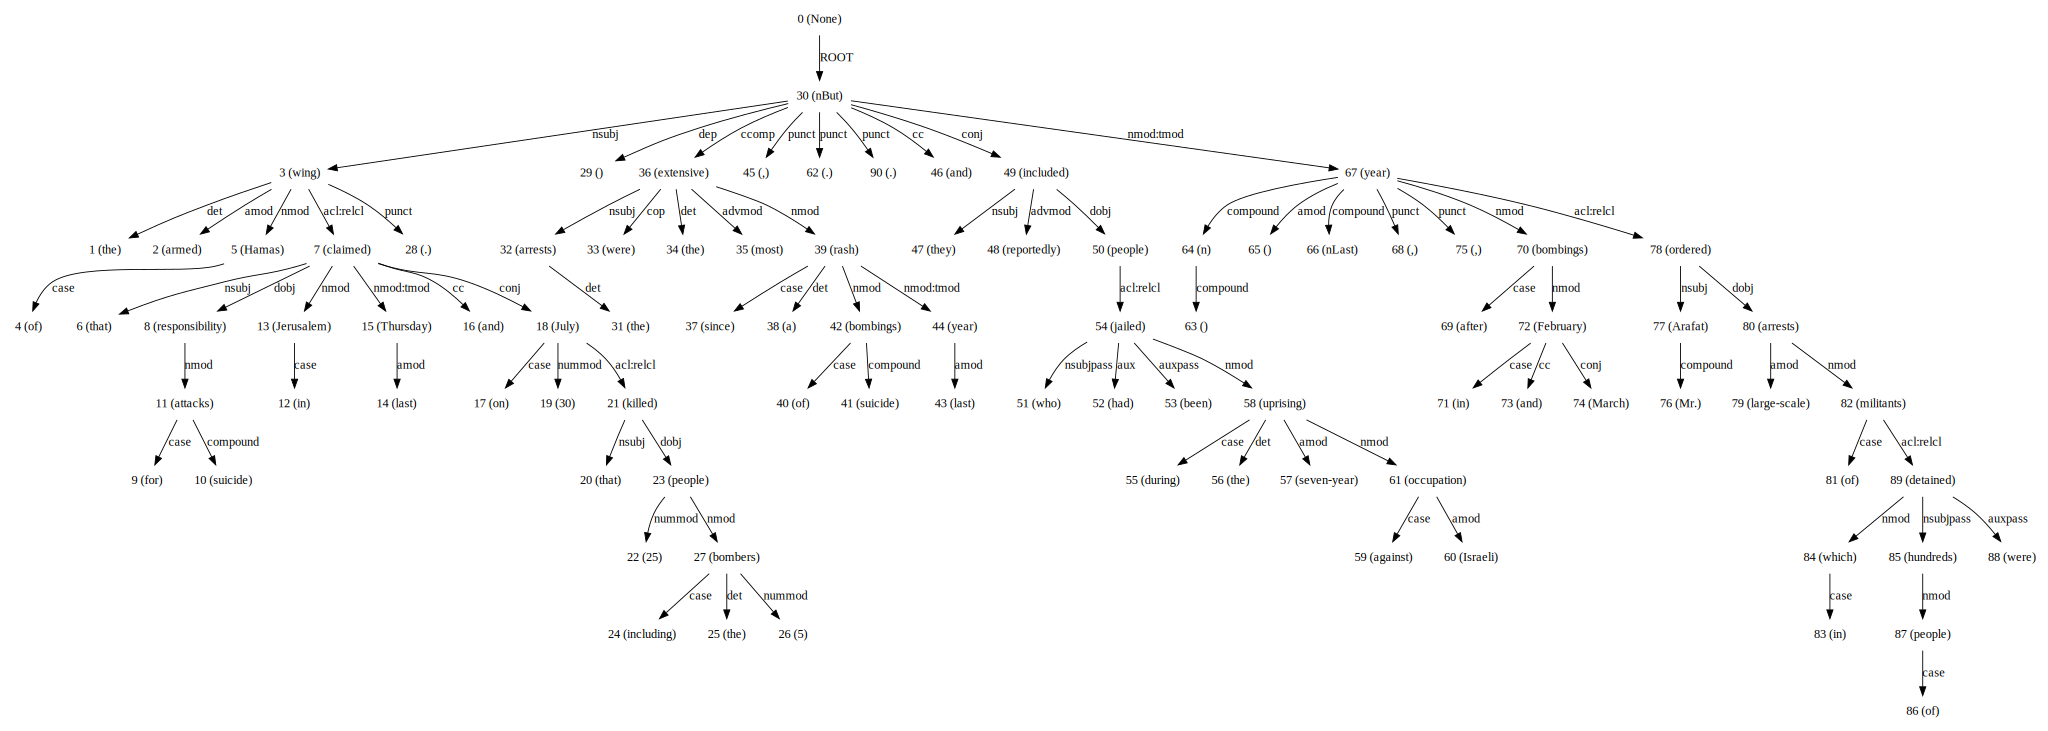

'Text =  the armed wing of Hamas that claimed responsibility for suicide attacks in Jerusalem last Thursday and on July 30 that killed 25 people including the 5 bombers.\\nBut the arrests were the most extensive since a rash of suicide bombings last year, and they reportedly included people who had been jailed during the seven-year uprising against Israeli occupation.\\n\\nLast year, after bombings in February and March, Mr. Arafat ordered large-scale arrests of militants in which hundreds of people were detained.'

'Code = 1831'

In [204]:
easy_read(SAME_AID_ACCENT_1831_CODED, 0)

# Extraneous Projects
#### py-CoreNLP Wrapper

In [137]:
from pycorenlp import StanfordCoreNLP

nlp = StanfordCoreNLP('http://localhost:9000')

def depparse(text):
    parsed=""
    output = nlp.annotate(text, properties={
      'annotators': 'depparse',
      'outputFormat': 'json'
      })

    for i in output["sentences"]:
        for j in i["basicDependencies"]:
            parsed=parsed+str(j["dep"]+'('+ j["governorGloss"]+' ')+str(j["dependentGloss"]+')'+' ')
        return parsed
text="I put the book in the box on the table."

#### Stanford NLP Python Package Parser
The sentence structure of the BBN/ACCENT output makes it impossible to loop through... going to need to do some REGEX work on it to get it into a format where sentences are not broken up. Assuming 'nlp' command breaks up sentences at any '.' which is going to be a problem when trying to clean it up. 

In [91]:
import stanfordnlp
stanfordnlp.download('en')   # This downloads the English models for the neural pipeline
nlp = stanfordnlp.Pipeline() # This sets up a default neural pipeline in English
doc = nlp("Barack Obama was born in Hawaii.  He was elected president in 2008.")
doc.sentences[0].print_dependencies()

Using the default treebank "en_ewt" for language "en".
Would you like to download the models for: en_ewt now? (Y/n)
Y

Default download directory: /Users/jonathanbonaguro/stanfordnlp_resources
Hit enter to continue or type an alternate directory.


Download location: /Users/jonathanbonaguro/stanfordnlp_resources/en_ewt_models.zip


100%|██████████| 235M/235M [02:58<00:00, 1.30MB/s] 



Download complete.  Models saved to: /Users/jonathanbonaguro/stanfordnlp_resources/en_ewt_models.zip
Extracting models file for: en_ewt
Cleaning up...Done.
Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/Users/jonathanbonaguro/stanfordnlp_resources/en_ewt_models/en_ewt_tokenizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/Users/jonathanbonaguro/stanfordnlp_resources/en_ewt_models/en_ewt_tagger.pt', 'pretrain_path': '/Users/jonathanbonaguro/stanfordnlp_resources/en_ewt_models/en_ewt.pretrain.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/Users/jonathanbonaguro/stanfordnlp_resources/en_ewt_models/en_ewt_lemmatizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit cla

../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


In [92]:
def stanlp(df, col):
    for i in range(len(df)):
        arg = nlp(df[col].iloc[i])
    return arg

In [93]:
flop = stanlp(protest_violent, "text")

../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATe

In [97]:
flop.sentences[2].print_dependencies()

('The', '2', 'det')
('crowd', '14', 'nsubj')
('in', '4', 'case')
('Sidon', '2', 'nmod')
('today', '2', 'nmod:tmod')
(',', '2', 'punct')
('led', '2', 'acl')
('by', '10', 'case')
('the', '10', 'det')
('Party', '7', 'obl')
('of', '12', 'case')
('God', '10', 'nmod')
(',', '14', 'punct')
('staged', '0', 'root')
('a', '16', 'det')
('rally', '14', 'obj')
('in', '18', 'case')
('front', '14', 'obl')
('of', '22', 'case')
('the', '22', 'det')
('main', '22', 'amod')
('mosque', '18', 'nmod')
('and', '24', 'cc')
('rounded', '14', 'conj')
('out', '24', 'compound:prt')
('the', '27', 'det')
('day', '24', 'obl:tmod')
('by', '29', 'mark')
('burning', '24', 'advcl')
('three', '31', 'nummod')
('bars', '29', 'obj')
('and', '33', 'cc')
('smashing', '29', 'conj')
('whisky', '35', 'compound')
('bottles', '33', 'obj')
('in', '38', 'case')
('several', '38', 'amod')
('stores', '33', 'obl')
(',', '33', 'punct')
('according', '42', 'case')
('to', '40', 'fixed')
('reports', '29', 'obl')
('reaching', '42', 'acl')
('t